# 2번째 시도
- 1-10일 데이터를 넣으면 11일 종가를 예측했는데, 실용적으로 사용하기엔 오차가 컸다. 
- 원래 오픈소스대로 1-10일 데이터 넣으면 12일의 종가를 예측해주는 오프셋2번해서 진행해보겠다.
- model_test 폴더에 저장

# 결과정리
- 맨 아래 실제 현재애플 비교그래프를 기존 CNN과 비교했을때 큰 차이점은 없어보인다.

In [1]:
# GPU Check
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Name:", gpu.name, "Type:", gpu.device_type)
        print("Num GPUs Available: ", len(gpus))

Name: /physical_device:GPU:0 Type: GPU
Num GPUs Available:  1


# 1. 데이터 준비
- 주가데이터 전처리된 모습을 보며 학습데이터셋을 어떻게 전처리하여 준비해야할지 본다.
- 코인의 데이터를 로드하여 비슷한형태로 전처리한다.

In [2]:
import yfinance
import numpy as np
import tensorflow as tf
from keras.models import load_model, model_from_json
import os
from keras import callbacks

In [3]:
# Original datasetb
df = yfinance.download('AAPL','2000-1-1','2020-1-1')
df = df.drop(['Volume'],1).drop(['Adj Close'],1)
display(df)

[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_92325/1698183863.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_92325/1698183863.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)


,Open,High,Low,Close
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497
2019-12-26,71.205002,72.495003,71.175003,72.477501
2019-12-27,72.779999,73.492500,72.029999,72.449997


# 2. 데이터셋 정규화

In [4]:
# 정규화 0~1
def normalize_data(dataset):
    cols = dataset.columns.tolist()
    # 편의상 모든컬럼명을 인덱스(실수)로 바꿈
    col_name = [0]*len(cols)          # [0, 0, 0, 0]
    for i in range(len(cols)):
        col_name[i] = i               # [0, 1, 2, 3]
    dataset.columns = col_name
    dtypes = dataset.dtypes.tolist()
    minmax = list()
    for column in dataset:
        dataset = dataset.astype({column: 'float32'})
    # 각 컬럼의 min, max 저장(정규화를 위함)
    for i in range(len(cols)):
        col_values = dataset[col_name[i]]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    # 0~1사이값으로 정규화
    for column in dataset:
        values = dataset[column].values
        for i in range(len(values)):
            values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
        dataset[column] = values
    dataset[column] = values
    return dataset,minmax
    

dataset, minmax = normalize_data(df)
values = dataset.values
display("< df >", df.head(21), "< dataset >", dataset.head(21))
# 종가 예측은 11번째부터 시작 (1.18일부터)

'< df >'

,0,1,2,3
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
2000-01-10,0.910714,0.912946,0.845982,0.872768
2000-01-11,0.856585,0.887277,0.808036,0.828125
2000-01-12,0.848214,0.852679,0.772321,0.778460
2000-01-13,0.843610,0.881696,0.825893,0.863839


'< dataset >'

,0,1,2,3
Date,,,,
2000-01-03,0.009710,0.010496,0.009435,0.010456
2000-01-04,0.010125,0.010268,0.009373,0.009305
2000-01-05,0.009571,0.010260,0.009598,0.009488
2000-01-06,0.009864,0.009826,0.008608,0.008389
2000-01-07,0.008679,0.009095,0.008670,0.008939
2000-01-10,0.009356,0.009247,0.008577,0.008725
2000-01-11,0.008610,0.008897,0.008051,0.008115
2000-01-12,0.008494,0.008424,0.007556,0.007436
2000-01-13,0.008431,0.008820,0.008298,0.008603


# 데이터전처리 , 스플릿

In [7]:
def split_sequences(sequence, n_steps):
    X,y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1: 
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # 오프셋 정렬
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    

def data_setup(n_steps, sequence):
    X, y = split_sequences(sequence, n_steps)
    print("< X > \n",X[:2],X.shape)                   # X : 10일분의 데이터묶음이 5021개
    print("< y > \n",y[:3],y.shape)                   # y : X의 각 묶음의 마지막날의 다음날데이터(예측할 타겟)
    n_features = X.shape[2]                       # X의 피쳐(특성) 수
    X = X.reshape((len(X), n_steps, n_features))  # 형태재구성 (샘플 수, 시퀀스 길이, 특성 수)
    # 
    new_y = []
    for term in y:
        new_term = term[-1]                       # 종가 컬럼만 추출
        new_y.append(new_term)
    return X, np.array(new_y), n_features

n_steps = 10        # 10일 분량
rel_test_len = 0.1  # 트 : 테 = 9 : 1
X,y,n_features = data_setup(n_steps, values)
# 다음날 종가데이터와 맵핑하기 위해 한스텝씩 오프셋정렬한다.
# 이 부분 추가
X = X[:-1]
y = y[1:]

X_test, y_test =  X[:int(len(X) * rel_test_len)], y[:int(len(X) * rel_test_len)]
X_train, y_train = X[int(len(X) * rel_test_len):], y[int(len(X) * rel_test_len):]

# print("< Last X >\n",X[:3], X.shape, len(X))
print(" < last y > \n",y[:10], y.shape)
print(" < test y > \n",y_test[:10])
print("< n_features >\n",n_features)

# array([0.9280131 , 0.95145106, 1.013393  , 0.99386203, 0.948661  ,
#        1.002232  , 0.98381704, 0.982143  , 0.907366  , 0.92633903],

< X > 
 [[[0.0097097  0.01049631 0.00943526 0.01045606]
  [0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]]

 [[0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]
  [0.00923281 0.0097041  0.00928058 0.00947997]]] (5021, 10, 4)
< y > 
 [[0.00

# CNN

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model = Sequential()
model.add(Conv1D(
    filters=128,
    kernel_size=3,
    activation='relu',
    input_shape=(10,4)))
model.add(Conv1D(
    filters=64,
    kernel_size=3,
    activation='relu'
))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mse', optimizer='adam')

2024-01-22 21:58:55.756915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-22 21:58:55.757424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro


# 네트워크 훈련 / 저장
- ModelCheckpoint : Keras API에서 제공하는 콜백(callback) 중 하나로, 모델을 학습하는 동안 특정 조건을 만족하는 시점에 모델의 가중치를 자동으로 저장 
  
여기서는 검증 데이터셋의 손실이 가장 낮을 때 모델의 가중치를 저장

In [9]:
# 학습 후, 콜백 저장
import os
from keras import callbacks
epochs = 5000
verbosity = 2
dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test'
os.chdir(dirx)
h5 = 'CNN_network.h5' # 학습된 모델의 최적의 가중치 저장
checkpoint = callbacks.ModelCheckpoint(h5,
                                      monitor='val_loss',
                                      verbose=0,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='auto',
                                      period=1)
callback = [checkpoint]
json = 'CNN_network.json' # 모델 저장
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
history = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=len(X_train) // 4,
                   validation_data = (X_test, y_test),
                   verbose = verbosity,
                   callbacks = callback)

Epoch 1/5000


2024-01-22 21:59:30.356822: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-22 21:59:30.548053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 - 3s - loss: 0.1248 - val_loss: 0.2324 - 3s/epoch - 526ms/step
Epoch 2/5000
5/5 - 0s - loss: 0.1178 - val_loss: 0.2111 - 54ms/epoch - 11ms/step
Epoch 3/5000


2024-01-22 21:59:32.890511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 - 0s - loss: 0.1068 - val_loss: 0.1807 - 51ms/epoch - 10ms/step
Epoch 4/5000
5/5 - 0s - loss: 0.0877 - val_loss: 0.1378 - 46ms/epoch - 9ms/step
Epoch 5/5000
5/5 - 0s - loss: 0.0606 - val_loss: 0.0843 - 43ms/epoch - 9ms/step
Epoch 6/5000
5/5 - 0s - loss: 0.0316 - val_loss: 0.0364 - 48ms/epoch - 10ms/step
Epoch 7/5000
5/5 - 0s - loss: 0.0098 - val_loss: 0.0102 - 45ms/epoch - 9ms/step
Epoch 8/5000
5/5 - 0s - loss: 0.0032 - val_loss: 0.0032 - 40ms/epoch - 8ms/step
Epoch 9/5000
5/5 - 0s - loss: 0.0034 - val_loss: 0.0013 - 44ms/epoch - 9ms/step
Epoch 10/5000
5/5 - 0s - loss: 0.0032 - val_loss: 0.0012 - 45ms/epoch - 9ms/step
Epoch 11/5000
5/5 - 0s - loss: 0.0022 - val_loss: 0.0013 - 44ms/epoch - 9ms/step
Epoch 12/5000
5/5 - 0s - loss: 0.0016 - val_loss: 0.0018 - 35ms/epoch - 7ms/step
Epoch 13/5000
5/5 - 0s - loss: 0.0011 - val_loss: 0.0019 - 36ms/epoch - 7ms/step
Epoch 14/5000
5/5 - 0s - loss: 0.0010 - val_loss: 0.0016 - 36ms/epoch - 7ms/step
Epoch 15/5000
5/5 - 0s - loss: 8.7622e-04 - va

Epoch 97/5000
5/5 - 0s - loss: 2.3128e-04 - val_loss: 1.1905e-04 - 31ms/epoch - 6ms/step
Epoch 98/5000
5/5 - 0s - loss: 2.3462e-04 - val_loss: 1.1868e-04 - 38ms/epoch - 8ms/step
Epoch 99/5000
5/5 - 0s - loss: 2.2792e-04 - val_loss: 1.1819e-04 - 32ms/epoch - 6ms/step
Epoch 100/5000
5/5 - 0s - loss: 3.5467e-04 - val_loss: 1.0044e-04 - 46ms/epoch - 9ms/step
Epoch 101/5000
5/5 - 0s - loss: 3.2158e-04 - val_loss: 1.3080e-04 - 35ms/epoch - 7ms/step
Epoch 102/5000
5/5 - 0s - loss: 3.6454e-04 - val_loss: 1.1482e-04 - 38ms/epoch - 8ms/step
Epoch 103/5000
5/5 - 0s - loss: 2.9600e-04 - val_loss: 1.3095e-04 - 35ms/epoch - 7ms/step
Epoch 104/5000
5/5 - 0s - loss: 2.3217e-04 - val_loss: 1.1870e-04 - 50ms/epoch - 10ms/step
Epoch 105/5000
5/5 - 0s - loss: 5.6355e-04 - val_loss: 7.8264e-05 - 46ms/epoch - 9ms/step
Epoch 106/5000
5/5 - 0s - loss: 5.0065e-04 - val_loss: 1.1038e-04 - 38ms/epoch - 8ms/step
Epoch 107/5000
5/5 - 0s - loss: 3.6737e-04 - val_loss: 1.0316e-04 - 36ms/epoch - 7ms/step
Epoch 108/50

Epoch 189/5000
5/5 - 0s - loss: 1.6325e-04 - val_loss: 4.2675e-05 - 40ms/epoch - 8ms/step
Epoch 190/5000
5/5 - 0s - loss: 4.6085e-04 - val_loss: 3.7006e-05 - 43ms/epoch - 9ms/step
Epoch 191/5000
5/5 - 0s - loss: 2.4886e-04 - val_loss: 6.1147e-05 - 38ms/epoch - 8ms/step
Epoch 192/5000
5/5 - 0s - loss: 2.2755e-04 - val_loss: 5.7223e-05 - 39ms/epoch - 8ms/step
Epoch 193/5000
5/5 - 0s - loss: 1.9578e-04 - val_loss: 6.0169e-05 - 35ms/epoch - 7ms/step
Epoch 194/5000
5/5 - 0s - loss: 1.8148e-04 - val_loss: 3.8244e-05 - 34ms/epoch - 7ms/step
Epoch 195/5000
5/5 - 0s - loss: 1.7246e-04 - val_loss: 3.0843e-05 - 46ms/epoch - 9ms/step
Epoch 196/5000
5/5 - 0s - loss: 2.5291e-04 - val_loss: 3.7838e-05 - 39ms/epoch - 8ms/step
Epoch 197/5000
5/5 - 0s - loss: 2.5309e-04 - val_loss: 4.2408e-05 - 37ms/epoch - 7ms/step
Epoch 198/5000
5/5 - 0s - loss: 1.9338e-04 - val_loss: 4.7544e-05 - 40ms/epoch - 8ms/step
Epoch 199/5000
5/5 - 0s - loss: 1.7177e-04 - val_loss: 4.5839e-05 - 38ms/epoch - 8ms/step
Epoch 200/

5/5 - 0s - loss: 1.7789e-04 - val_loss: 2.5996e-05 - 36ms/epoch - 7ms/step
Epoch 281/5000
5/5 - 0s - loss: 1.7812e-04 - val_loss: 3.3691e-05 - 37ms/epoch - 7ms/step
Epoch 282/5000
5/5 - 0s - loss: 1.6730e-04 - val_loss: 2.0865e-05 - 37ms/epoch - 7ms/step
Epoch 283/5000
5/5 - 0s - loss: 3.3436e-04 - val_loss: 1.4291e-05 - 42ms/epoch - 8ms/step
Epoch 284/5000
5/5 - 0s - loss: 8.5818e-04 - val_loss: 3.7429e-05 - 35ms/epoch - 7ms/step
Epoch 285/5000
5/5 - 0s - loss: 3.7683e-04 - val_loss: 2.4611e-05 - 34ms/epoch - 7ms/step
Epoch 286/5000
5/5 - 0s - loss: 4.1640e-04 - val_loss: 1.8995e-05 - 36ms/epoch - 7ms/step
Epoch 287/5000
5/5 - 0s - loss: 2.3352e-04 - val_loss: 1.4750e-05 - 40ms/epoch - 8ms/step
Epoch 288/5000
5/5 - 0s - loss: 2.3190e-04 - val_loss: 1.7789e-05 - 32ms/epoch - 6ms/step
Epoch 289/5000
5/5 - 0s - loss: 1.8254e-04 - val_loss: 4.1172e-05 - 37ms/epoch - 7ms/step
Epoch 290/5000
5/5 - 0s - loss: 2.7774e-04 - val_loss: 3.4220e-05 - 35ms/epoch - 7ms/step
Epoch 291/5000
5/5 - 0s -

Epoch 372/5000
5/5 - 0s - loss: 2.9764e-04 - val_loss: 1.3404e-05 - 37ms/epoch - 7ms/step
Epoch 373/5000
5/5 - 0s - loss: 3.6247e-04 - val_loss: 1.2353e-05 - 35ms/epoch - 7ms/step
Epoch 374/5000
5/5 - 0s - loss: 2.2609e-04 - val_loss: 1.4817e-05 - 37ms/epoch - 7ms/step
Epoch 375/5000
5/5 - 0s - loss: 2.3315e-04 - val_loss: 2.6926e-05 - 36ms/epoch - 7ms/step
Epoch 376/5000
5/5 - 0s - loss: 1.5906e-04 - val_loss: 1.6105e-05 - 35ms/epoch - 7ms/step
Epoch 377/5000
5/5 - 0s - loss: 1.4483e-04 - val_loss: 1.4527e-05 - 64ms/epoch - 13ms/step
Epoch 378/5000
5/5 - 0s - loss: 1.4762e-04 - val_loss: 1.4048e-05 - 43ms/epoch - 9ms/step
Epoch 379/5000
5/5 - 0s - loss: 1.3994e-04 - val_loss: 1.6734e-05 - 38ms/epoch - 8ms/step
Epoch 380/5000
5/5 - 0s - loss: 1.6452e-04 - val_loss: 1.2448e-05 - 35ms/epoch - 7ms/step
Epoch 381/5000
5/5 - 0s - loss: 2.2034e-04 - val_loss: 1.4054e-05 - 40ms/epoch - 8ms/step
Epoch 382/5000
5/5 - 0s - loss: 1.9336e-04 - val_loss: 1.2596e-05 - 34ms/epoch - 7ms/step
Epoch 383

5/5 - 0s - loss: 5.7378e-04 - val_loss: 4.6766e-05 - 38ms/epoch - 8ms/step
Epoch 464/5000
5/5 - 0s - loss: 0.0010 - val_loss: 1.3059e-05 - 35ms/epoch - 7ms/step
Epoch 465/5000
5/5 - 0s - loss: 4.7050e-04 - val_loss: 1.4883e-05 - 38ms/epoch - 8ms/step
Epoch 466/5000
5/5 - 0s - loss: 5.4840e-04 - val_loss: 1.0398e-05 - 36ms/epoch - 7ms/step
Epoch 467/5000
5/5 - 0s - loss: 2.2182e-04 - val_loss: 4.6967e-05 - 41ms/epoch - 8ms/step
Epoch 468/5000
5/5 - 0s - loss: 2.5670e-04 - val_loss: 1.2484e-05 - 35ms/epoch - 7ms/step
Epoch 469/5000
5/5 - 0s - loss: 1.7428e-04 - val_loss: 1.2833e-05 - 41ms/epoch - 8ms/step
Epoch 470/5000
5/5 - 0s - loss: 1.8185e-04 - val_loss: 1.2243e-05 - 37ms/epoch - 7ms/step
Epoch 471/5000
5/5 - 0s - loss: 1.6253e-04 - val_loss: 1.3324e-05 - 44ms/epoch - 9ms/step
Epoch 472/5000
5/5 - 0s - loss: 1.5030e-04 - val_loss: 1.6790e-05 - 46ms/epoch - 9ms/step
Epoch 473/5000
5/5 - 0s - loss: 1.4314e-04 - val_loss: 1.5787e-05 - 47ms/epoch - 9ms/step
Epoch 474/5000
5/5 - 0s - los

Epoch 555/5000
5/5 - 0s - loss: 2.5705e-04 - val_loss: 1.2013e-05 - 36ms/epoch - 7ms/step
Epoch 556/5000
5/5 - 0s - loss: 2.7714e-04 - val_loss: 1.0717e-05 - 42ms/epoch - 8ms/step
Epoch 557/5000
5/5 - 0s - loss: 2.6032e-04 - val_loss: 1.3316e-05 - 39ms/epoch - 8ms/step
Epoch 558/5000
5/5 - 0s - loss: 2.6974e-04 - val_loss: 1.1940e-05 - 36ms/epoch - 7ms/step
Epoch 559/5000
5/5 - 0s - loss: 2.2712e-04 - val_loss: 9.9321e-06 - 35ms/epoch - 7ms/step
Epoch 560/5000
5/5 - 0s - loss: 1.9963e-04 - val_loss: 9.4732e-06 - 36ms/epoch - 7ms/step
Epoch 561/5000
5/5 - 0s - loss: 2.7464e-04 - val_loss: 1.0253e-05 - 34ms/epoch - 7ms/step
Epoch 562/5000
5/5 - 0s - loss: 3.3200e-04 - val_loss: 1.0280e-05 - 37ms/epoch - 7ms/step
Epoch 563/5000
5/5 - 0s - loss: 3.5032e-04 - val_loss: 9.5080e-06 - 36ms/epoch - 7ms/step
Epoch 564/5000
5/5 - 0s - loss: 2.2802e-04 - val_loss: 1.1396e-05 - 35ms/epoch - 7ms/step
Epoch 565/5000
5/5 - 0s - loss: 1.8444e-04 - val_loss: 1.0470e-05 - 39ms/epoch - 8ms/step
Epoch 566/

5/5 - 0s - loss: 1.1283e-04 - val_loss: 7.5318e-06 - 31ms/epoch - 6ms/step
Epoch 647/5000
5/5 - 0s - loss: 1.1295e-04 - val_loss: 7.8747e-06 - 35ms/epoch - 7ms/step
Epoch 648/5000
5/5 - 0s - loss: 1.0466e-04 - val_loss: 9.9761e-06 - 40ms/epoch - 8ms/step
Epoch 649/5000
5/5 - 0s - loss: 1.0409e-04 - val_loss: 1.0293e-05 - 30ms/epoch - 6ms/step
Epoch 650/5000
5/5 - 0s - loss: 1.0218e-04 - val_loss: 8.0762e-06 - 37ms/epoch - 7ms/step
Epoch 651/5000
5/5 - 0s - loss: 1.0012e-04 - val_loss: 7.1639e-06 - 42ms/epoch - 8ms/step
Epoch 652/5000
5/5 - 0s - loss: 9.9383e-05 - val_loss: 7.0989e-06 - 38ms/epoch - 8ms/step
Epoch 653/5000
5/5 - 0s - loss: 1.3129e-04 - val_loss: 6.9376e-06 - 42ms/epoch - 8ms/step
Epoch 654/5000
5/5 - 0s - loss: 1.1610e-04 - val_loss: 6.8932e-06 - 39ms/epoch - 8ms/step
Epoch 655/5000
5/5 - 0s - loss: 1.1464e-04 - val_loss: 7.1746e-06 - 37ms/epoch - 7ms/step
Epoch 656/5000
5/5 - 0s - loss: 8.6979e-04 - val_loss: 1.2083e-05 - 42ms/epoch - 8ms/step
Epoch 657/5000
5/5 - 0s -

Epoch 738/5000
5/5 - 0s - loss: 1.1258e-04 - val_loss: 6.0818e-06 - 39ms/epoch - 8ms/step
Epoch 739/5000
5/5 - 0s - loss: 1.0322e-04 - val_loss: 6.0560e-06 - 37ms/epoch - 7ms/step
Epoch 740/5000
5/5 - 0s - loss: 9.8436e-05 - val_loss: 6.9541e-06 - 41ms/epoch - 8ms/step
Epoch 741/5000
5/5 - 0s - loss: 1.2400e-04 - val_loss: 5.8855e-06 - 43ms/epoch - 9ms/step
Epoch 742/5000
5/5 - 0s - loss: 1.0186e-04 - val_loss: 8.1613e-06 - 36ms/epoch - 7ms/step
Epoch 743/5000
5/5 - 0s - loss: 2.3621e-04 - val_loss: 7.4401e-06 - 35ms/epoch - 7ms/step
Epoch 744/5000
5/5 - 0s - loss: 2.2459e-04 - val_loss: 6.9653e-06 - 38ms/epoch - 8ms/step
Epoch 745/5000
5/5 - 0s - loss: 1.8533e-04 - val_loss: 8.0855e-06 - 38ms/epoch - 8ms/step
Epoch 746/5000
5/5 - 0s - loss: 2.0173e-04 - val_loss: 8.5664e-06 - 36ms/epoch - 7ms/step
Epoch 747/5000
5/5 - 0s - loss: 1.6616e-04 - val_loss: 6.1196e-06 - 31ms/epoch - 6ms/step
Epoch 748/5000
5/5 - 0s - loss: 1.6201e-04 - val_loss: 6.1677e-06 - 37ms/epoch - 7ms/step
Epoch 749/

5/5 - 0s - loss: 2.6051e-04 - val_loss: 5.5030e-06 - 34ms/epoch - 7ms/step
Epoch 830/5000
5/5 - 0s - loss: 2.7914e-04 - val_loss: 1.2676e-05 - 40ms/epoch - 8ms/step
Epoch 831/5000
5/5 - 0s - loss: 2.1114e-04 - val_loss: 6.0086e-06 - 29ms/epoch - 6ms/step
Epoch 832/5000
5/5 - 0s - loss: 1.4759e-04 - val_loss: 6.4747e-06 - 37ms/epoch - 7ms/step
Epoch 833/5000
5/5 - 0s - loss: 2.0834e-04 - val_loss: 5.0506e-06 - 35ms/epoch - 7ms/step
Epoch 834/5000
5/5 - 0s - loss: 1.3818e-04 - val_loss: 5.3867e-06 - 35ms/epoch - 7ms/step
Epoch 835/5000
5/5 - 0s - loss: 1.2043e-04 - val_loss: 6.7781e-06 - 30ms/epoch - 6ms/step
Epoch 836/5000
5/5 - 0s - loss: 3.5208e-04 - val_loss: 5.2594e-06 - 37ms/epoch - 7ms/step
Epoch 837/5000
5/5 - 0s - loss: 1.3169e-04 - val_loss: 5.2640e-06 - 35ms/epoch - 7ms/step
Epoch 838/5000
5/5 - 0s - loss: 1.0539e-04 - val_loss: 5.3244e-06 - 36ms/epoch - 7ms/step
Epoch 839/5000
5/5 - 0s - loss: 1.0616e-04 - val_loss: 5.3048e-06 - 30ms/epoch - 6ms/step
Epoch 840/5000
5/5 - 0s -

Epoch 921/5000
5/5 - 0s - loss: 1.0488e-04 - val_loss: 6.6762e-06 - 39ms/epoch - 8ms/step
Epoch 922/5000
5/5 - 0s - loss: 1.0209e-04 - val_loss: 6.5053e-06 - 37ms/epoch - 7ms/step
Epoch 923/5000
5/5 - 0s - loss: 1.7153e-04 - val_loss: 6.0294e-06 - 37ms/epoch - 7ms/step
Epoch 924/5000
5/5 - 0s - loss: 1.1479e-04 - val_loss: 6.8159e-06 - 33ms/epoch - 7ms/step
Epoch 925/5000
5/5 - 0s - loss: 1.2179e-04 - val_loss: 6.7559e-06 - 35ms/epoch - 7ms/step
Epoch 926/5000
5/5 - 0s - loss: 5.4096e-04 - val_loss: 9.6550e-06 - 37ms/epoch - 7ms/step
Epoch 927/5000
5/5 - 0s - loss: 0.0030 - val_loss: 1.4589e-04 - 36ms/epoch - 7ms/step
Epoch 928/5000
5/5 - 0s - loss: 0.0013 - val_loss: 1.6347e-05 - 40ms/epoch - 8ms/step
Epoch 929/5000
5/5 - 0s - loss: 0.0012 - val_loss: 1.1913e-05 - 30ms/epoch - 6ms/step
Epoch 930/5000
5/5 - 0s - loss: 6.1841e-04 - val_loss: 3.2283e-05 - 35ms/epoch - 7ms/step
Epoch 931/5000
5/5 - 0s - loss: 6.1219e-04 - val_loss: 3.9335e-05 - 39ms/epoch - 8ms/step
Epoch 932/5000
5/5 - 0

5/5 - 0s - loss: 1.2273e-04 - val_loss: 8.8465e-06 - 38ms/epoch - 8ms/step
Epoch 1013/5000
5/5 - 0s - loss: 1.5472e-04 - val_loss: 9.4232e-06 - 36ms/epoch - 7ms/step
Epoch 1014/5000
5/5 - 0s - loss: 1.4391e-04 - val_loss: 5.8694e-06 - 41ms/epoch - 8ms/step
Epoch 1015/5000
5/5 - 0s - loss: 1.7139e-04 - val_loss: 5.9991e-06 - 40ms/epoch - 8ms/step
Epoch 1016/5000
5/5 - 0s - loss: 1.1493e-04 - val_loss: 5.7235e-06 - 44ms/epoch - 9ms/step
Epoch 1017/5000
5/5 - 0s - loss: 1.0134e-04 - val_loss: 6.5514e-06 - 42ms/epoch - 8ms/step
Epoch 1018/5000
5/5 - 0s - loss: 9.0553e-05 - val_loss: 6.7988e-06 - 42ms/epoch - 8ms/step
Epoch 1019/5000
5/5 - 0s - loss: 1.2987e-04 - val_loss: 8.9113e-06 - 41ms/epoch - 8ms/step
Epoch 1020/5000
5/5 - 0s - loss: 1.0281e-04 - val_loss: 5.7821e-06 - 34ms/epoch - 7ms/step
Epoch 1021/5000
5/5 - 0s - loss: 1.0187e-04 - val_loss: 6.5728e-06 - 36ms/epoch - 7ms/step
Epoch 1022/5000
5/5 - 0s - loss: 1.3237e-04 - val_loss: 5.7837e-06 - 40ms/epoch - 8ms/step
Epoch 1023/5000

Epoch 1103/5000
5/5 - 0s - loss: 5.7087e-04 - val_loss: 8.7167e-06 - 39ms/epoch - 8ms/step
Epoch 1104/5000
5/5 - 0s - loss: 3.5222e-04 - val_loss: 1.4318e-05 - 35ms/epoch - 7ms/step
Epoch 1105/5000
5/5 - 0s - loss: 1.9335e-04 - val_loss: 1.0120e-05 - 34ms/epoch - 7ms/step
Epoch 1106/5000
5/5 - 0s - loss: 1.7175e-04 - val_loss: 4.8224e-06 - 40ms/epoch - 8ms/step
Epoch 1107/5000
5/5 - 0s - loss: 1.4557e-04 - val_loss: 5.5007e-06 - 30ms/epoch - 6ms/step
Epoch 1108/5000
5/5 - 0s - loss: 1.6903e-04 - val_loss: 9.5748e-06 - 34ms/epoch - 7ms/step
Epoch 1109/5000
5/5 - 0s - loss: 1.0595e-04 - val_loss: 4.9762e-06 - 34ms/epoch - 7ms/step
Epoch 1110/5000
5/5 - 0s - loss: 9.4088e-05 - val_loss: 6.0106e-06 - 39ms/epoch - 8ms/step
Epoch 1111/5000
5/5 - 0s - loss: 1.3518e-04 - val_loss: 4.1966e-06 - 29ms/epoch - 6ms/step
Epoch 1112/5000
5/5 - 0s - loss: 9.1000e-05 - val_loss: 8.4362e-06 - 35ms/epoch - 7ms/step
Epoch 1113/5000
5/5 - 0s - loss: 1.0298e-04 - val_loss: 4.3209e-06 - 48ms/epoch - 10ms/ste

Epoch 1193/5000
5/5 - 0s - loss: 1.5508e-04 - val_loss: 4.5378e-06 - 41ms/epoch - 8ms/step
Epoch 1194/5000
5/5 - 0s - loss: 1.2868e-04 - val_loss: 3.6678e-06 - 34ms/epoch - 7ms/step
Epoch 1195/5000
5/5 - 0s - loss: 1.5425e-04 - val_loss: 4.5592e-06 - 42ms/epoch - 8ms/step
Epoch 1196/5000
5/5 - 0s - loss: 1.4941e-04 - val_loss: 7.7490e-06 - 45ms/epoch - 9ms/step
Epoch 1197/5000
5/5 - 0s - loss: 1.3820e-04 - val_loss: 3.3878e-06 - 38ms/epoch - 8ms/step
Epoch 1198/5000
5/5 - 0s - loss: 1.1777e-04 - val_loss: 3.3369e-06 - 45ms/epoch - 9ms/step
Epoch 1199/5000
5/5 - 0s - loss: 1.1232e-04 - val_loss: 6.3027e-06 - 40ms/epoch - 8ms/step
Epoch 1200/5000
5/5 - 0s - loss: 2.1494e-04 - val_loss: 3.3284e-06 - 43ms/epoch - 9ms/step
Epoch 1201/5000
5/5 - 0s - loss: 1.4974e-04 - val_loss: 6.1494e-06 - 38ms/epoch - 8ms/step
Epoch 1202/5000
5/5 - 0s - loss: 1.7552e-04 - val_loss: 4.5846e-06 - 41ms/epoch - 8ms/step
Epoch 1203/5000
5/5 - 0s - loss: 1.6431e-04 - val_loss: 3.5788e-06 - 36ms/epoch - 7ms/step

Epoch 1283/5000
5/5 - 0s - loss: 1.9645e-04 - val_loss: 5.3363e-06 - 32ms/epoch - 6ms/step
Epoch 1284/5000
5/5 - 0s - loss: 1.4271e-04 - val_loss: 3.9296e-06 - 36ms/epoch - 7ms/step
Epoch 1285/5000
5/5 - 0s - loss: 1.3508e-04 - val_loss: 4.0195e-06 - 37ms/epoch - 7ms/step
Epoch 1286/5000
5/5 - 0s - loss: 1.1328e-04 - val_loss: 4.2061e-06 - 32ms/epoch - 6ms/step
Epoch 1287/5000
5/5 - 0s - loss: 1.0717e-04 - val_loss: 5.6618e-06 - 37ms/epoch - 7ms/step
Epoch 1288/5000
5/5 - 0s - loss: 1.1528e-04 - val_loss: 3.7257e-06 - 34ms/epoch - 7ms/step
Epoch 1289/5000
5/5 - 0s - loss: 1.0198e-04 - val_loss: 3.4735e-06 - 39ms/epoch - 8ms/step
Epoch 1290/5000
5/5 - 0s - loss: 1.1632e-04 - val_loss: 3.6031e-06 - 33ms/epoch - 7ms/step
Epoch 1291/5000
5/5 - 0s - loss: 1.0397e-04 - val_loss: 5.7825e-06 - 34ms/epoch - 7ms/step
Epoch 1292/5000
5/5 - 0s - loss: 1.0402e-04 - val_loss: 4.1671e-06 - 34ms/epoch - 7ms/step
Epoch 1293/5000
5/5 - 0s - loss: 9.8603e-05 - val_loss: 3.0863e-06 - 39ms/epoch - 8ms/step

5/5 - 0s - loss: 1.0693e-04 - val_loss: 3.6114e-06 - 39ms/epoch - 8ms/step
Epoch 1374/5000
5/5 - 0s - loss: 1.0806e-04 - val_loss: 3.3645e-06 - 36ms/epoch - 7ms/step
Epoch 1375/5000
5/5 - 0s - loss: 1.0117e-04 - val_loss: 3.6099e-06 - 34ms/epoch - 7ms/step
Epoch 1376/5000
5/5 - 0s - loss: 1.6437e-04 - val_loss: 4.8586e-06 - 36ms/epoch - 7ms/step
Epoch 1377/5000
5/5 - 0s - loss: 9.7717e-05 - val_loss: 7.1162e-06 - 32ms/epoch - 6ms/step
Epoch 1378/5000
5/5 - 0s - loss: 9.1412e-05 - val_loss: 3.9862e-06 - 35ms/epoch - 7ms/step
Epoch 1379/5000
5/5 - 0s - loss: 8.6359e-05 - val_loss: 3.4582e-06 - 34ms/epoch - 7ms/step
Epoch 1380/5000
5/5 - 0s - loss: 8.2269e-05 - val_loss: 8.3080e-06 - 34ms/epoch - 7ms/step
Epoch 1381/5000
5/5 - 0s - loss: 7.7821e-05 - val_loss: 6.0896e-06 - 36ms/epoch - 7ms/step
Epoch 1382/5000
5/5 - 0s - loss: 7.9514e-05 - val_loss: 3.2866e-06 - 34ms/epoch - 7ms/step
Epoch 1383/5000
5/5 - 0s - loss: 8.0057e-05 - val_loss: 2.9536e-06 - 31ms/epoch - 6ms/step
Epoch 1384/5000

5/5 - 0s - loss: 1.7622e-04 - val_loss: 5.4903e-06 - 38ms/epoch - 8ms/step
Epoch 1464/5000
5/5 - 0s - loss: 1.7410e-04 - val_loss: 2.4318e-06 - 33ms/epoch - 7ms/step
Epoch 1465/5000
5/5 - 0s - loss: 1.4854e-04 - val_loss: 2.4018e-06 - 35ms/epoch - 7ms/step
Epoch 1466/5000
5/5 - 0s - loss: 1.5659e-04 - val_loss: 4.7403e-06 - 38ms/epoch - 8ms/step
Epoch 1467/5000
5/5 - 0s - loss: 3.1173e-04 - val_loss: 4.1618e-06 - 36ms/epoch - 7ms/step
Epoch 1468/5000
5/5 - 0s - loss: 1.6301e-04 - val_loss: 2.5807e-06 - 42ms/epoch - 8ms/step
Epoch 1469/5000
5/5 - 0s - loss: 3.2406e-04 - val_loss: 5.0972e-06 - 38ms/epoch - 8ms/step
Epoch 1470/5000
5/5 - 0s - loss: 1.9177e-04 - val_loss: 1.4451e-05 - 36ms/epoch - 7ms/step
Epoch 1471/5000
5/5 - 0s - loss: 1.3750e-04 - val_loss: 2.7277e-06 - 33ms/epoch - 7ms/step
Epoch 1472/5000
5/5 - 0s - loss: 9.7500e-05 - val_loss: 1.1822e-05 - 34ms/epoch - 7ms/step
Epoch 1473/5000
5/5 - 0s - loss: 9.2638e-05 - val_loss: 8.6629e-06 - 41ms/epoch - 8ms/step
Epoch 1474/5000

Epoch 1554/5000
5/5 - 0s - loss: 8.0854e-05 - val_loss: 2.7647e-06 - 45ms/epoch - 9ms/step
Epoch 1555/5000
5/5 - 0s - loss: 7.0572e-05 - val_loss: 4.4893e-06 - 35ms/epoch - 7ms/step
Epoch 1556/5000
5/5 - 0s - loss: 7.4520e-05 - val_loss: 2.6710e-06 - 35ms/epoch - 7ms/step
Epoch 1557/5000
5/5 - 0s - loss: 7.2798e-05 - val_loss: 2.5195e-06 - 41ms/epoch - 8ms/step
Epoch 1558/5000
5/5 - 0s - loss: 7.2064e-05 - val_loss: 3.0222e-06 - 33ms/epoch - 7ms/step
Epoch 1559/5000
5/5 - 0s - loss: 7.3044e-05 - val_loss: 3.5380e-06 - 40ms/epoch - 8ms/step
Epoch 1560/5000
5/5 - 0s - loss: 9.8435e-05 - val_loss: 2.9774e-06 - 30ms/epoch - 6ms/step
Epoch 1561/5000
5/5 - 0s - loss: 9.6531e-05 - val_loss: 7.3103e-06 - 36ms/epoch - 7ms/step
Epoch 1562/5000
5/5 - 0s - loss: 8.3472e-05 - val_loss: 2.1737e-06 - 32ms/epoch - 6ms/step
Epoch 1563/5000
5/5 - 0s - loss: 1.0615e-04 - val_loss: 2.2104e-06 - 40ms/epoch - 8ms/step
Epoch 1564/5000
5/5 - 0s - loss: 8.4306e-05 - val_loss: 1.9877e-06 - 43ms/epoch - 9ms/step

5/5 - 0s - loss: 9.3461e-05 - val_loss: 2.0975e-06 - 37ms/epoch - 7ms/step
Epoch 1645/5000
5/5 - 0s - loss: 1.4199e-04 - val_loss: 4.2029e-06 - 38ms/epoch - 8ms/step
Epoch 1646/5000
5/5 - 0s - loss: 1.1116e-04 - val_loss: 2.7524e-06 - 34ms/epoch - 7ms/step
Epoch 1647/5000
5/5 - 0s - loss: 8.7998e-05 - val_loss: 2.2002e-06 - 38ms/epoch - 8ms/step
Epoch 1648/5000
5/5 - 0s - loss: 8.0511e-05 - val_loss: 9.6491e-06 - 36ms/epoch - 7ms/step
Epoch 1649/5000
5/5 - 0s - loss: 1.1822e-04 - val_loss: 2.4597e-06 - 34ms/epoch - 7ms/step
Epoch 1650/5000
5/5 - 0s - loss: 1.5182e-04 - val_loss: 4.1440e-06 - 35ms/epoch - 7ms/step
Epoch 1651/5000
5/5 - 0s - loss: 8.7423e-05 - val_loss: 2.0805e-06 - 31ms/epoch - 6ms/step
Epoch 1652/5000
5/5 - 0s - loss: 2.0792e-04 - val_loss: 2.8171e-06 - 36ms/epoch - 7ms/step
Epoch 1653/5000
5/5 - 0s - loss: 2.1743e-04 - val_loss: 6.6813e-06 - 33ms/epoch - 7ms/step
Epoch 1654/5000
5/5 - 0s - loss: 1.5143e-04 - val_loss: 4.7056e-06 - 41ms/epoch - 8ms/step
Epoch 1655/5000

Epoch 1735/5000
5/5 - 0s - loss: 8.6991e-05 - val_loss: 5.8323e-06 - 36ms/epoch - 7ms/step
Epoch 1736/5000
5/5 - 0s - loss: 1.5050e-04 - val_loss: 5.1446e-06 - 35ms/epoch - 7ms/step
Epoch 1737/5000
5/5 - 0s - loss: 1.2761e-04 - val_loss: 2.0210e-06 - 37ms/epoch - 7ms/step
Epoch 1738/5000
5/5 - 0s - loss: 8.5776e-05 - val_loss: 2.0618e-06 - 35ms/epoch - 7ms/step
Epoch 1739/5000
5/5 - 0s - loss: 9.7163e-05 - val_loss: 2.6977e-06 - 41ms/epoch - 8ms/step
Epoch 1740/5000
5/5 - 0s - loss: 1.1749e-04 - val_loss: 2.2649e-06 - 32ms/epoch - 6ms/step
Epoch 1741/5000
5/5 - 0s - loss: 1.1859e-04 - val_loss: 2.3475e-06 - 43ms/epoch - 9ms/step
Epoch 1742/5000
5/5 - 0s - loss: 9.5725e-05 - val_loss: 3.1297e-06 - 36ms/epoch - 7ms/step
Epoch 1743/5000
5/5 - 0s - loss: 8.0194e-05 - val_loss: 1.8469e-06 - 50ms/epoch - 10ms/step
Epoch 1744/5000
5/5 - 0s - loss: 7.3331e-05 - val_loss: 2.9404e-06 - 35ms/epoch - 7ms/step
Epoch 1745/5000
5/5 - 0s - loss: 7.3577e-05 - val_loss: 2.0473e-06 - 42ms/epoch - 8ms/ste

Epoch 1825/5000
5/5 - 0s - loss: 8.5453e-05 - val_loss: 2.6948e-06 - 33ms/epoch - 7ms/step
Epoch 1826/5000
5/5 - 0s - loss: 8.2911e-05 - val_loss: 1.8242e-06 - 40ms/epoch - 8ms/step
Epoch 1827/5000
5/5 - 0s - loss: 4.9463e-04 - val_loss: 6.2444e-06 - 36ms/epoch - 7ms/step
Epoch 1828/5000
5/5 - 0s - loss: 2.6084e-04 - val_loss: 2.6417e-06 - 36ms/epoch - 7ms/step
Epoch 1829/5000
5/5 - 0s - loss: 3.7389e-04 - val_loss: 6.5690e-06 - 36ms/epoch - 7ms/step
Epoch 1830/5000
5/5 - 0s - loss: 4.8573e-04 - val_loss: 1.9474e-05 - 41ms/epoch - 8ms/step
Epoch 1831/5000
5/5 - 0s - loss: 3.3869e-04 - val_loss: 5.2607e-06 - 37ms/epoch - 7ms/step
Epoch 1832/5000
5/5 - 0s - loss: 2.9970e-04 - val_loss: 3.1840e-06 - 35ms/epoch - 7ms/step
Epoch 1833/5000
5/5 - 0s - loss: 2.6190e-04 - val_loss: 3.1214e-06 - 38ms/epoch - 8ms/step
Epoch 1834/5000
5/5 - 0s - loss: 1.5450e-04 - val_loss: 7.8400e-06 - 35ms/epoch - 7ms/step
Epoch 1835/5000
5/5 - 0s - loss: 9.8421e-05 - val_loss: 3.5339e-06 - 41ms/epoch - 8ms/step

5/5 - 0s - loss: 9.9381e-05 - val_loss: 2.6955e-06 - 36ms/epoch - 7ms/step
Epoch 1916/5000
5/5 - 0s - loss: 8.5096e-05 - val_loss: 6.7907e-06 - 34ms/epoch - 7ms/step
Epoch 1917/5000
5/5 - 0s - loss: 1.1040e-04 - val_loss: 6.7172e-06 - 39ms/epoch - 8ms/step
Epoch 1918/5000
5/5 - 0s - loss: 1.2953e-04 - val_loss: 1.8008e-06 - 34ms/epoch - 7ms/step
Epoch 1919/5000
5/5 - 0s - loss: 1.4604e-04 - val_loss: 2.0953e-06 - 34ms/epoch - 7ms/step
Epoch 1920/5000
5/5 - 0s - loss: 1.2962e-04 - val_loss: 8.6522e-06 - 34ms/epoch - 7ms/step
Epoch 1921/5000
5/5 - 0s - loss: 9.4532e-05 - val_loss: 1.8682e-06 - 33ms/epoch - 7ms/step
Epoch 1922/5000
5/5 - 0s - loss: 2.1065e-04 - val_loss: 2.1218e-06 - 35ms/epoch - 7ms/step
Epoch 1923/5000
5/5 - 0s - loss: 1.5014e-04 - val_loss: 1.1782e-05 - 35ms/epoch - 7ms/step
Epoch 1924/5000
5/5 - 0s - loss: 1.3903e-04 - val_loss: 1.8766e-06 - 35ms/epoch - 7ms/step
Epoch 1925/5000
5/5 - 0s - loss: 9.9466e-05 - val_loss: 1.8417e-06 - 34ms/epoch - 7ms/step
Epoch 1926/5000

Epoch 2006/5000
5/5 - 0s - loss: 4.0124e-04 - val_loss: 1.4088e-05 - 33ms/epoch - 7ms/step
Epoch 2007/5000
5/5 - 0s - loss: 1.8822e-04 - val_loss: 3.7705e-06 - 38ms/epoch - 8ms/step
Epoch 2008/5000
5/5 - 0s - loss: 1.6907e-04 - val_loss: 7.8129e-06 - 34ms/epoch - 7ms/step
Epoch 2009/5000
5/5 - 0s - loss: 2.1891e-04 - val_loss: 4.1573e-06 - 38ms/epoch - 8ms/step
Epoch 2010/5000
5/5 - 0s - loss: 1.5764e-04 - val_loss: 1.2625e-05 - 36ms/epoch - 7ms/step
Epoch 2011/5000
5/5 - 0s - loss: 1.0123e-04 - val_loss: 1.7225e-06 - 41ms/epoch - 8ms/step
Epoch 2012/5000
5/5 - 0s - loss: 1.0525e-04 - val_loss: 1.9580e-06 - 37ms/epoch - 7ms/step
Epoch 2013/5000
5/5 - 0s - loss: 8.9359e-05 - val_loss: 1.6742e-06 - 38ms/epoch - 8ms/step
Epoch 2014/5000
5/5 - 0s - loss: 7.7260e-05 - val_loss: 5.5229e-06 - 37ms/epoch - 7ms/step
Epoch 2015/5000
5/5 - 0s - loss: 1.0166e-04 - val_loss: 2.2703e-06 - 36ms/epoch - 7ms/step
Epoch 2016/5000
5/5 - 0s - loss: 1.4660e-04 - val_loss: 2.3628e-06 - 34ms/epoch - 7ms/step

5/5 - 0s - loss: 8.1219e-05 - val_loss: 1.5809e-06 - 41ms/epoch - 8ms/step
Epoch 2097/5000
5/5 - 0s - loss: 3.5438e-04 - val_loss: 3.4048e-06 - 36ms/epoch - 7ms/step
Epoch 2098/5000
5/5 - 0s - loss: 1.7007e-04 - val_loss: 2.9609e-06 - 37ms/epoch - 7ms/step
Epoch 2099/5000
5/5 - 0s - loss: 1.4197e-04 - val_loss: 2.7843e-06 - 37ms/epoch - 7ms/step
Epoch 2100/5000
5/5 - 0s - loss: 1.0247e-04 - val_loss: 2.9557e-06 - 36ms/epoch - 7ms/step
Epoch 2101/5000
5/5 - 0s - loss: 8.9874e-05 - val_loss: 2.1207e-06 - 37ms/epoch - 7ms/step
Epoch 2102/5000
5/5 - 0s - loss: 1.6561e-04 - val_loss: 2.2911e-06 - 37ms/epoch - 7ms/step
Epoch 2103/5000
5/5 - 0s - loss: 1.0462e-04 - val_loss: 2.8249e-06 - 38ms/epoch - 8ms/step
Epoch 2104/5000
5/5 - 0s - loss: 1.0540e-04 - val_loss: 3.3452e-06 - 34ms/epoch - 7ms/step
Epoch 2105/5000
5/5 - 0s - loss: 7.6526e-05 - val_loss: 4.2736e-06 - 43ms/epoch - 9ms/step
Epoch 2106/5000
5/5 - 0s - loss: 7.5635e-05 - val_loss: 1.5815e-06 - 39ms/epoch - 8ms/step
Epoch 2107/5000

Epoch 2187/5000
5/5 - 0s - loss: 1.1636e-04 - val_loss: 1.7259e-06 - 31ms/epoch - 6ms/step
Epoch 2188/5000
5/5 - 0s - loss: 8.2848e-05 - val_loss: 1.8942e-06 - 36ms/epoch - 7ms/step
Epoch 2189/5000
5/5 - 0s - loss: 8.8398e-05 - val_loss: 4.8995e-06 - 39ms/epoch - 8ms/step
Epoch 2190/5000
5/5 - 0s - loss: 8.3588e-05 - val_loss: 4.5400e-06 - 30ms/epoch - 6ms/step
Epoch 2191/5000
5/5 - 0s - loss: 8.3728e-05 - val_loss: 2.5037e-06 - 36ms/epoch - 7ms/step
Epoch 2192/5000
5/5 - 0s - loss: 8.2397e-05 - val_loss: 1.9447e-06 - 37ms/epoch - 7ms/step
Epoch 2193/5000
5/5 - 0s - loss: 7.0855e-05 - val_loss: 2.1835e-06 - 29ms/epoch - 6ms/step
Epoch 2194/5000
5/5 - 0s - loss: 7.3622e-05 - val_loss: 2.5227e-06 - 38ms/epoch - 8ms/step
Epoch 2195/5000
5/5 - 0s - loss: 2.5280e-04 - val_loss: 1.8700e-06 - 30ms/epoch - 6ms/step
Epoch 2196/5000
5/5 - 0s - loss: 1.6055e-04 - val_loss: 9.0479e-06 - 36ms/epoch - 7ms/step
Epoch 2197/5000
5/5 - 0s - loss: 2.2888e-04 - val_loss: 2.1123e-06 - 36ms/epoch - 7ms/step

5/5 - 0s - loss: 8.0272e-05 - val_loss: 2.1967e-06 - 34ms/epoch - 7ms/step
Epoch 2278/5000
5/5 - 0s - loss: 8.3325e-05 - val_loss: 1.9900e-06 - 40ms/epoch - 8ms/step
Epoch 2279/5000
5/5 - 0s - loss: 7.1778e-05 - val_loss: 2.0200e-06 - 31ms/epoch - 6ms/step
Epoch 2280/5000
5/5 - 0s - loss: 8.3805e-05 - val_loss: 3.2813e-06 - 36ms/epoch - 7ms/step
Epoch 2281/5000
5/5 - 0s - loss: 8.1069e-05 - val_loss: 1.8144e-06 - 37ms/epoch - 7ms/step
Epoch 2282/5000
5/5 - 0s - loss: 9.8169e-05 - val_loss: 1.8321e-06 - 30ms/epoch - 6ms/step
Epoch 2283/5000
5/5 - 0s - loss: 8.0637e-05 - val_loss: 1.8155e-06 - 38ms/epoch - 8ms/step
Epoch 2284/5000
5/5 - 0s - loss: 1.1142e-04 - val_loss: 3.0650e-06 - 33ms/epoch - 7ms/step
Epoch 2285/5000
5/5 - 0s - loss: 1.1223e-04 - val_loss: 1.8570e-06 - 39ms/epoch - 8ms/step
Epoch 2286/5000
5/5 - 0s - loss: 1.2250e-04 - val_loss: 2.7760e-06 - 36ms/epoch - 7ms/step
Epoch 2287/5000
5/5 - 0s - loss: 9.0317e-05 - val_loss: 4.2333e-06 - 35ms/epoch - 7ms/step
Epoch 2288/5000

Epoch 2368/5000
5/5 - 0s - loss: 7.8037e-05 - val_loss: 2.7205e-06 - 34ms/epoch - 7ms/step
Epoch 2369/5000
5/5 - 0s - loss: 7.3888e-05 - val_loss: 2.5915e-06 - 36ms/epoch - 7ms/step
Epoch 2370/5000
5/5 - 0s - loss: 7.9494e-05 - val_loss: 4.0240e-06 - 40ms/epoch - 8ms/step
Epoch 2371/5000
5/5 - 0s - loss: 1.0787e-04 - val_loss: 2.2126e-06 - 33ms/epoch - 7ms/step
Epoch 2372/5000
5/5 - 0s - loss: 1.8131e-04 - val_loss: 4.3372e-06 - 42ms/epoch - 8ms/step
Epoch 2373/5000
5/5 - 0s - loss: 1.1191e-04 - val_loss: 2.2278e-06 - 37ms/epoch - 7ms/step
Epoch 2374/5000
5/5 - 0s - loss: 1.1204e-04 - val_loss: 3.0532e-06 - 35ms/epoch - 7ms/step
Epoch 2375/5000
5/5 - 0s - loss: 8.5350e-05 - val_loss: 2.6672e-06 - 38ms/epoch - 8ms/step
Epoch 2376/5000
5/5 - 0s - loss: 2.4014e-04 - val_loss: 4.3927e-06 - 31ms/epoch - 6ms/step
Epoch 2377/5000
5/5 - 0s - loss: 1.2421e-04 - val_loss: 2.1612e-06 - 40ms/epoch - 8ms/step
Epoch 2378/5000
5/5 - 0s - loss: 1.0969e-04 - val_loss: 2.6188e-06 - 36ms/epoch - 7ms/step

5/5 - 0s - loss: 7.9289e-05 - val_loss: 1.7833e-06 - 39ms/epoch - 8ms/step
Epoch 2459/5000
5/5 - 0s - loss: 7.7728e-05 - val_loss: 2.9828e-06 - 37ms/epoch - 7ms/step
Epoch 2460/5000
5/5 - 0s - loss: 7.4984e-05 - val_loss: 9.2137e-06 - 41ms/epoch - 8ms/step
Epoch 2461/5000
5/5 - 0s - loss: 7.1147e-05 - val_loss: 6.0620e-06 - 33ms/epoch - 7ms/step
Epoch 2462/5000
5/5 - 0s - loss: 1.8663e-04 - val_loss: 3.3966e-06 - 34ms/epoch - 7ms/step
Epoch 2463/5000
5/5 - 0s - loss: 1.1378e-04 - val_loss: 4.2655e-06 - 39ms/epoch - 8ms/step
Epoch 2464/5000
5/5 - 0s - loss: 9.6409e-05 - val_loss: 1.7819e-06 - 30ms/epoch - 6ms/step
Epoch 2465/5000
5/5 - 0s - loss: 1.1722e-04 - val_loss: 1.6137e-06 - 37ms/epoch - 7ms/step
Epoch 2466/5000
5/5 - 0s - loss: 8.1412e-05 - val_loss: 1.9206e-06 - 37ms/epoch - 7ms/step
Epoch 2467/5000
5/5 - 0s - loss: 7.9899e-05 - val_loss: 1.7591e-06 - 35ms/epoch - 7ms/step
Epoch 2468/5000
5/5 - 0s - loss: 7.5198e-05 - val_loss: 3.8316e-06 - 31ms/epoch - 6ms/step
Epoch 2469/5000

Epoch 2549/5000
5/5 - 0s - loss: 9.9864e-05 - val_loss: 4.3536e-06 - 41ms/epoch - 8ms/step
Epoch 2550/5000
5/5 - 0s - loss: 9.2367e-05 - val_loss: 2.4685e-06 - 35ms/epoch - 7ms/step
Epoch 2551/5000
5/5 - 0s - loss: 7.4755e-05 - val_loss: 2.7722e-06 - 40ms/epoch - 8ms/step
Epoch 2552/5000
5/5 - 0s - loss: 7.4734e-05 - val_loss: 3.9666e-06 - 33ms/epoch - 7ms/step
Epoch 2553/5000
5/5 - 0s - loss: 1.2578e-04 - val_loss: 4.5984e-06 - 35ms/epoch - 7ms/step
Epoch 2554/5000
5/5 - 0s - loss: 9.4663e-05 - val_loss: 7.4324e-06 - 39ms/epoch - 8ms/step
Epoch 2555/5000
5/5 - 0s - loss: 8.1262e-05 - val_loss: 4.6282e-06 - 35ms/epoch - 7ms/step
Epoch 2556/5000
5/5 - 0s - loss: 7.1701e-05 - val_loss: 2.0145e-06 - 41ms/epoch - 8ms/step
Epoch 2557/5000
5/5 - 0s - loss: 3.1317e-04 - val_loss: 4.6001e-06 - 36ms/epoch - 7ms/step
Epoch 2558/5000
5/5 - 0s - loss: 2.0157e-04 - val_loss: 1.8803e-06 - 42ms/epoch - 8ms/step
Epoch 2559/5000
5/5 - 0s - loss: 1.4636e-04 - val_loss: 3.4345e-06 - 37ms/epoch - 7ms/step

5/5 - 0s - loss: 6.4883e-05 - val_loss: 2.1952e-06 - 44ms/epoch - 9ms/step
Epoch 2640/5000
5/5 - 0s - loss: 6.5876e-05 - val_loss: 2.2569e-06 - 41ms/epoch - 8ms/step
Epoch 2641/5000
5/5 - 0s - loss: 6.5100e-05 - val_loss: 1.5854e-06 - 39ms/epoch - 8ms/step
Epoch 2642/5000
5/5 - 0s - loss: 6.5218e-05 - val_loss: 1.6717e-06 - 40ms/epoch - 8ms/step
Epoch 2643/5000
5/5 - 0s - loss: 1.3361e-04 - val_loss: 1.5649e-06 - 39ms/epoch - 8ms/step
Epoch 2644/5000
5/5 - 0s - loss: 6.7315e-04 - val_loss: 2.3308e-05 - 41ms/epoch - 8ms/step
Epoch 2645/5000
5/5 - 0s - loss: 4.9271e-04 - val_loss: 2.3294e-06 - 40ms/epoch - 8ms/step
Epoch 2646/5000
5/5 - 0s - loss: 2.9540e-04 - val_loss: 1.7565e-05 - 41ms/epoch - 8ms/step
Epoch 2647/5000
5/5 - 0s - loss: 2.3621e-04 - val_loss: 2.4513e-06 - 44ms/epoch - 9ms/step
Epoch 2648/5000
5/5 - 0s - loss: 2.1339e-04 - val_loss: 2.6508e-06 - 46ms/epoch - 9ms/step
Epoch 2649/5000
5/5 - 0s - loss: 8.1193e-05 - val_loss: 1.8238e-06 - 46ms/epoch - 9ms/step
Epoch 2650/5000

5/5 - 0s - loss: 7.6875e-05 - val_loss: 1.5686e-06 - 48ms/epoch - 10ms/step
Epoch 2730/5000
5/5 - 0s - loss: 6.9628e-05 - val_loss: 2.9651e-06 - 45ms/epoch - 9ms/step
Epoch 2731/5000
5/5 - 0s - loss: 7.1901e-05 - val_loss: 1.6607e-06 - 46ms/epoch - 9ms/step
Epoch 2732/5000
5/5 - 0s - loss: 6.9555e-05 - val_loss: 1.6182e-06 - 48ms/epoch - 10ms/step
Epoch 2733/5000
5/5 - 0s - loss: 6.6692e-05 - val_loss: 1.9681e-06 - 47ms/epoch - 9ms/step
Epoch 2734/5000
5/5 - 0s - loss: 6.9263e-05 - val_loss: 1.7297e-06 - 42ms/epoch - 8ms/step
Epoch 2735/5000
5/5 - 0s - loss: 1.5256e-04 - val_loss: 3.0034e-06 - 39ms/epoch - 8ms/step
Epoch 2736/5000
5/5 - 0s - loss: 8.4706e-05 - val_loss: 1.8488e-06 - 40ms/epoch - 8ms/step
Epoch 2737/5000
5/5 - 0s - loss: 7.1311e-05 - val_loss: 1.5304e-06 - 41ms/epoch - 8ms/step
Epoch 2738/5000
5/5 - 0s - loss: 8.1493e-05 - val_loss: 1.7493e-06 - 35ms/epoch - 7ms/step
Epoch 2739/5000
5/5 - 0s - loss: 7.4950e-05 - val_loss: 1.4452e-06 - 51ms/epoch - 10ms/step
Epoch 2740/5

5/5 - 0s - loss: 7.6214e-05 - val_loss: 4.4016e-06 - 36ms/epoch - 7ms/step
Epoch 2820/5000
5/5 - 0s - loss: 6.9780e-05 - val_loss: 1.7097e-06 - 36ms/epoch - 7ms/step
Epoch 2821/5000
5/5 - 0s - loss: 6.7571e-05 - val_loss: 1.8041e-06 - 35ms/epoch - 7ms/step
Epoch 2822/5000
5/5 - 0s - loss: 6.8917e-05 - val_loss: 1.6260e-06 - 43ms/epoch - 9ms/step
Epoch 2823/5000
5/5 - 0s - loss: 7.7445e-05 - val_loss: 1.5384e-06 - 45ms/epoch - 9ms/step
Epoch 2824/5000
5/5 - 0s - loss: 6.7696e-05 - val_loss: 1.7673e-06 - 42ms/epoch - 8ms/step
Epoch 2825/5000
5/5 - 0s - loss: 6.5895e-05 - val_loss: 1.7181e-06 - 45ms/epoch - 9ms/step
Epoch 2826/5000
5/5 - 0s - loss: 6.5148e-05 - val_loss: 1.7168e-06 - 44ms/epoch - 9ms/step
Epoch 2827/5000
5/5 - 0s - loss: 1.0169e-04 - val_loss: 1.7909e-06 - 38ms/epoch - 8ms/step
Epoch 2828/5000
5/5 - 0s - loss: 6.8462e-05 - val_loss: 1.8486e-06 - 40ms/epoch - 8ms/step
Epoch 2829/5000
5/5 - 0s - loss: 7.8086e-05 - val_loss: 1.6950e-06 - 32ms/epoch - 6ms/step
Epoch 2830/5000

5/5 - 0s - loss: 8.3609e-05 - val_loss: 1.5635e-06 - 42ms/epoch - 8ms/step
Epoch 2910/5000
5/5 - 0s - loss: 7.5769e-05 - val_loss: 1.5047e-06 - 39ms/epoch - 8ms/step
Epoch 2911/5000
5/5 - 0s - loss: 7.4663e-05 - val_loss: 2.6954e-06 - 39ms/epoch - 8ms/step
Epoch 2912/5000
5/5 - 0s - loss: 7.7487e-05 - val_loss: 3.4627e-06 - 40ms/epoch - 8ms/step
Epoch 2913/5000
5/5 - 0s - loss: 1.5362e-04 - val_loss: 2.2765e-06 - 54ms/epoch - 11ms/step
Epoch 2914/5000
5/5 - 0s - loss: 1.0042e-04 - val_loss: 6.3585e-06 - 46ms/epoch - 9ms/step
Epoch 2915/5000
5/5 - 0s - loss: 7.7377e-05 - val_loss: 2.9478e-06 - 44ms/epoch - 9ms/step
Epoch 2916/5000
5/5 - 0s - loss: 1.0708e-04 - val_loss: 1.6936e-06 - 43ms/epoch - 9ms/step
Epoch 2917/5000
5/5 - 0s - loss: 7.6306e-05 - val_loss: 2.2726e-06 - 37ms/epoch - 7ms/step
Epoch 2918/5000
5/5 - 0s - loss: 7.7781e-05 - val_loss: 2.6809e-06 - 39ms/epoch - 8ms/step
Epoch 2919/5000
5/5 - 0s - loss: 2.3165e-04 - val_loss: 1.5867e-06 - 35ms/epoch - 7ms/step
Epoch 2920/500

Epoch 3000/5000
5/5 - 0s - loss: 6.9613e-05 - val_loss: 1.2524e-06 - 33ms/epoch - 7ms/step
Epoch 3001/5000
5/5 - 0s - loss: 6.8749e-05 - val_loss: 2.4244e-06 - 34ms/epoch - 7ms/step
Epoch 3002/5000
5/5 - 0s - loss: 6.7842e-05 - val_loss: 5.1077e-06 - 30ms/epoch - 6ms/step
Epoch 3003/5000
5/5 - 0s - loss: 9.6511e-05 - val_loss: 4.3927e-06 - 35ms/epoch - 7ms/step
Epoch 3004/5000
5/5 - 0s - loss: 7.8223e-05 - val_loss: 1.4668e-06 - 30ms/epoch - 6ms/step
Epoch 3005/5000
5/5 - 0s - loss: 6.9141e-05 - val_loss: 1.7763e-06 - 34ms/epoch - 7ms/step
Epoch 3006/5000
5/5 - 0s - loss: 1.1859e-04 - val_loss: 2.4070e-06 - 36ms/epoch - 7ms/step
Epoch 3007/5000
5/5 - 0s - loss: 9.1689e-05 - val_loss: 3.0692e-06 - 29ms/epoch - 6ms/step
Epoch 3008/5000
5/5 - 0s - loss: 7.8234e-05 - val_loss: 2.0878e-06 - 37ms/epoch - 7ms/step
Epoch 3009/5000
5/5 - 0s - loss: 7.6338e-05 - val_loss: 1.2618e-06 - 28ms/epoch - 6ms/step
Epoch 3010/5000
5/5 - 0s - loss: 7.1513e-05 - val_loss: 5.6249e-06 - 32ms/epoch - 6ms/step

5/5 - 0s - loss: 6.6519e-05 - val_loss: 2.6718e-06 - 38ms/epoch - 8ms/step
Epoch 3091/5000
5/5 - 0s - loss: 7.1902e-05 - val_loss: 1.1630e-06 - 40ms/epoch - 8ms/step
Epoch 3092/5000
5/5 - 0s - loss: 7.0231e-05 - val_loss: 1.7128e-06 - 34ms/epoch - 7ms/step
Epoch 3093/5000
5/5 - 0s - loss: 6.8525e-05 - val_loss: 1.3692e-06 - 39ms/epoch - 8ms/step
Epoch 3094/5000
5/5 - 0s - loss: 7.2096e-05 - val_loss: 1.7206e-06 - 36ms/epoch - 7ms/step
Epoch 3095/5000
5/5 - 0s - loss: 6.3024e-05 - val_loss: 1.8543e-06 - 38ms/epoch - 8ms/step
Epoch 3096/5000
5/5 - 0s - loss: 6.2883e-05 - val_loss: 1.4834e-06 - 39ms/epoch - 8ms/step
Epoch 3097/5000
5/5 - 0s - loss: 6.5545e-05 - val_loss: 1.1817e-06 - 38ms/epoch - 8ms/step
Epoch 3098/5000
5/5 - 0s - loss: 6.3130e-05 - val_loss: 1.7419e-06 - 35ms/epoch - 7ms/step
Epoch 3099/5000
5/5 - 0s - loss: 6.3673e-05 - val_loss: 2.5830e-06 - 32ms/epoch - 6ms/step
Epoch 3100/5000
5/5 - 0s - loss: 6.3373e-05 - val_loss: 1.4142e-06 - 32ms/epoch - 6ms/step
Epoch 3101/5000

Epoch 3181/5000
5/5 - 0s - loss: 4.3210e-04 - val_loss: 2.6147e-06 - 27ms/epoch - 5ms/step
Epoch 3182/5000
5/5 - 0s - loss: 3.1924e-04 - val_loss: 1.2769e-06 - 31ms/epoch - 6ms/step
Epoch 3183/5000
5/5 - 0s - loss: 2.1055e-04 - val_loss: 2.8114e-06 - 35ms/epoch - 7ms/step
Epoch 3184/5000
5/5 - 0s - loss: 2.1783e-04 - val_loss: 7.0161e-06 - 30ms/epoch - 6ms/step
Epoch 3185/5000
5/5 - 0s - loss: 2.4455e-04 - val_loss: 1.5247e-05 - 35ms/epoch - 7ms/step
Epoch 3186/5000
5/5 - 0s - loss: 1.3230e-04 - val_loss: 1.7511e-05 - 31ms/epoch - 6ms/step
Epoch 3187/5000
5/5 - 0s - loss: 1.1093e-04 - val_loss: 5.6636e-06 - 37ms/epoch - 7ms/step
Epoch 3188/5000
5/5 - 0s - loss: 1.2289e-04 - val_loss: 6.7407e-06 - 29ms/epoch - 6ms/step
Epoch 3189/5000
5/5 - 0s - loss: 2.7992e-04 - val_loss: 8.4157e-06 - 39ms/epoch - 8ms/step
Epoch 3190/5000
5/5 - 0s - loss: 1.5327e-04 - val_loss: 3.7065e-06 - 34ms/epoch - 7ms/step
Epoch 3191/5000
5/5 - 0s - loss: 1.3960e-04 - val_loss: 3.9749e-06 - 38ms/epoch - 8ms/step

5/5 - 0s - loss: 1.1319e-04 - val_loss: 2.7857e-06 - 43ms/epoch - 9ms/step
Epoch 3272/5000
5/5 - 0s - loss: 8.6872e-05 - val_loss: 1.0257e-06 - 34ms/epoch - 7ms/step
Epoch 3273/5000
5/5 - 0s - loss: 9.5334e-05 - val_loss: 1.0128e-06 - 51ms/epoch - 10ms/step
Epoch 3274/5000
5/5 - 0s - loss: 8.9617e-05 - val_loss: 4.1724e-06 - 42ms/epoch - 8ms/step
Epoch 3275/5000
5/5 - 0s - loss: 1.0083e-04 - val_loss: 1.9165e-06 - 38ms/epoch - 8ms/step
Epoch 3276/5000
5/5 - 0s - loss: 8.0628e-05 - val_loss: 1.1846e-06 - 42ms/epoch - 8ms/step
Epoch 3277/5000
5/5 - 0s - loss: 7.0240e-05 - val_loss: 1.3410e-06 - 40ms/epoch - 8ms/step
Epoch 3278/5000
5/5 - 0s - loss: 7.1940e-05 - val_loss: 1.6655e-06 - 46ms/epoch - 9ms/step
Epoch 3279/5000
5/5 - 0s - loss: 7.0766e-05 - val_loss: 1.8397e-06 - 42ms/epoch - 8ms/step
Epoch 3280/5000
5/5 - 0s - loss: 1.9032e-04 - val_loss: 9.4411e-07 - 44ms/epoch - 9ms/step
Epoch 3281/5000
5/5 - 0s - loss: 1.5346e-04 - val_loss: 4.1312e-06 - 38ms/epoch - 8ms/step
Epoch 3282/500

5/5 - 0s - loss: 6.6001e-05 - val_loss: 2.2394e-06 - 37ms/epoch - 7ms/step
Epoch 3362/5000
5/5 - 0s - loss: 6.4195e-05 - val_loss: 1.7935e-06 - 29ms/epoch - 6ms/step
Epoch 3363/5000
5/5 - 0s - loss: 7.7535e-05 - val_loss: 1.3031e-06 - 34ms/epoch - 7ms/step
Epoch 3364/5000
5/5 - 0s - loss: 6.7059e-05 - val_loss: 1.6829e-06 - 33ms/epoch - 7ms/step
Epoch 3365/5000
5/5 - 0s - loss: 7.7256e-05 - val_loss: 1.0486e-06 - 42ms/epoch - 8ms/step
Epoch 3366/5000
5/5 - 0s - loss: 6.7593e-05 - val_loss: 3.3083e-06 - 31ms/epoch - 6ms/step
Epoch 3367/5000
5/5 - 0s - loss: 6.7970e-05 - val_loss: 2.7587e-06 - 34ms/epoch - 7ms/step
Epoch 3368/5000
5/5 - 0s - loss: 6.3722e-05 - val_loss: 1.2175e-06 - 46ms/epoch - 9ms/step
Epoch 3369/5000
5/5 - 0s - loss: 6.9257e-05 - val_loss: 1.3943e-06 - 36ms/epoch - 7ms/step
Epoch 3370/5000
5/5 - 0s - loss: 6.4091e-05 - val_loss: 2.6092e-06 - 38ms/epoch - 8ms/step
Epoch 3371/5000
5/5 - 0s - loss: 9.5751e-05 - val_loss: 1.1532e-06 - 34ms/epoch - 7ms/step
Epoch 3372/5000

Epoch 3452/5000
5/5 - 0s - loss: 1.3889e-04 - val_loss: 1.3945e-06 - 29ms/epoch - 6ms/step
Epoch 3453/5000
5/5 - 0s - loss: 1.0405e-04 - val_loss: 1.6597e-06 - 36ms/epoch - 7ms/step
Epoch 3454/5000
5/5 - 0s - loss: 1.0160e-04 - val_loss: 1.6199e-06 - 35ms/epoch - 7ms/step
Epoch 3455/5000
5/5 - 0s - loss: 9.8796e-05 - val_loss: 1.2294e-06 - 28ms/epoch - 6ms/step
Epoch 3456/5000
5/5 - 0s - loss: 9.7889e-05 - val_loss: 2.2252e-06 - 38ms/epoch - 8ms/step
Epoch 3457/5000
5/5 - 0s - loss: 9.8620e-05 - val_loss: 3.3720e-06 - 29ms/epoch - 6ms/step
Epoch 3458/5000
5/5 - 0s - loss: 9.5113e-05 - val_loss: 3.1704e-06 - 34ms/epoch - 7ms/step
Epoch 3459/5000
5/5 - 0s - loss: 1.0090e-04 - val_loss: 1.8900e-06 - 33ms/epoch - 7ms/step
Epoch 3460/5000
5/5 - 0s - loss: 9.1393e-05 - val_loss: 1.8115e-06 - 32ms/epoch - 6ms/step
Epoch 3461/5000
5/5 - 0s - loss: 9.1914e-05 - val_loss: 4.4227e-06 - 31ms/epoch - 6ms/step
Epoch 3462/5000
5/5 - 0s - loss: 9.1343e-05 - val_loss: 4.0201e-06 - 31ms/epoch - 6ms/step

5/5 - 0s - loss: 9.0051e-05 - val_loss: 5.1489e-06 - 29ms/epoch - 6ms/step
Epoch 3543/5000
5/5 - 0s - loss: 8.1169e-05 - val_loss: 1.2257e-06 - 32ms/epoch - 6ms/step
Epoch 3544/5000
5/5 - 0s - loss: 8.1584e-05 - val_loss: 1.3102e-06 - 33ms/epoch - 7ms/step
Epoch 3545/5000
5/5 - 0s - loss: 7.4914e-05 - val_loss: 2.6026e-06 - 33ms/epoch - 7ms/step
Epoch 3546/5000
5/5 - 0s - loss: 7.2137e-05 - val_loss: 1.6804e-06 - 32ms/epoch - 6ms/step
Epoch 3547/5000
5/5 - 0s - loss: 8.2181e-05 - val_loss: 3.7876e-06 - 32ms/epoch - 6ms/step
Epoch 3548/5000
5/5 - 0s - loss: 7.5561e-05 - val_loss: 5.9688e-06 - 35ms/epoch - 7ms/step
Epoch 3549/5000
5/5 - 0s - loss: 7.3693e-05 - val_loss: 2.6477e-06 - 30ms/epoch - 6ms/step
Epoch 3550/5000
5/5 - 0s - loss: 6.7956e-05 - val_loss: 1.5334e-06 - 34ms/epoch - 7ms/step
Epoch 3551/5000
5/5 - 0s - loss: 7.2516e-05 - val_loss: 1.9024e-06 - 31ms/epoch - 6ms/step
Epoch 3552/5000
5/5 - 0s - loss: 6.5971e-05 - val_loss: 3.2434e-06 - 31ms/epoch - 6ms/step
Epoch 3553/5000

Epoch 3633/5000
5/5 - 0s - loss: 7.2576e-05 - val_loss: 2.8243e-06 - 35ms/epoch - 7ms/step
Epoch 3634/5000
5/5 - 0s - loss: 6.7644e-05 - val_loss: 3.1164e-06 - 28ms/epoch - 6ms/step
Epoch 3635/5000
5/5 - 0s - loss: 9.4825e-05 - val_loss: 3.1775e-06 - 39ms/epoch - 8ms/step
Epoch 3636/5000
5/5 - 0s - loss: 1.1745e-04 - val_loss: 1.7568e-06 - 29ms/epoch - 6ms/step
Epoch 3637/5000
5/5 - 0s - loss: 8.1019e-05 - val_loss: 9.5486e-07 - 33ms/epoch - 7ms/step
Epoch 3638/5000
5/5 - 0s - loss: 8.9931e-05 - val_loss: 3.1252e-06 - 31ms/epoch - 6ms/step
Epoch 3639/5000
5/5 - 0s - loss: 1.2947e-04 - val_loss: 4.1955e-06 - 31ms/epoch - 6ms/step
Epoch 3640/5000
5/5 - 0s - loss: 8.8315e-05 - val_loss: 1.1167e-06 - 30ms/epoch - 6ms/step
Epoch 3641/5000
5/5 - 0s - loss: 1.0362e-04 - val_loss: 8.9259e-07 - 38ms/epoch - 8ms/step
Epoch 3642/5000
5/5 - 0s - loss: 9.2537e-05 - val_loss: 5.8933e-06 - 37ms/epoch - 7ms/step
Epoch 3643/5000
5/5 - 0s - loss: 1.9721e-04 - val_loss: 2.4330e-06 - 31ms/epoch - 6ms/step

5/5 - 0s - loss: 1.0502e-04 - val_loss: 1.3759e-06 - 34ms/epoch - 7ms/step
Epoch 3724/5000
5/5 - 0s - loss: 9.6576e-05 - val_loss: 2.1695e-06 - 35ms/epoch - 7ms/step
Epoch 3725/5000
5/5 - 0s - loss: 7.5019e-05 - val_loss: 3.3911e-06 - 29ms/epoch - 6ms/step
Epoch 3726/5000
5/5 - 0s - loss: 6.7742e-05 - val_loss: 1.2916e-06 - 37ms/epoch - 7ms/step
Epoch 3727/5000
5/5 - 0s - loss: 6.6812e-05 - val_loss: 1.8417e-06 - 33ms/epoch - 7ms/step
Epoch 3728/5000
5/5 - 0s - loss: 6.9742e-05 - val_loss: 1.7029e-06 - 33ms/epoch - 7ms/step
Epoch 3729/5000
5/5 - 0s - loss: 7.5806e-05 - val_loss: 2.0725e-06 - 33ms/epoch - 7ms/step
Epoch 3730/5000
5/5 - 0s - loss: 9.2034e-05 - val_loss: 1.3417e-06 - 36ms/epoch - 7ms/step
Epoch 3731/5000
5/5 - 0s - loss: 8.3629e-05 - val_loss: 1.6900e-06 - 31ms/epoch - 6ms/step
Epoch 3732/5000
5/5 - 0s - loss: 8.6251e-05 - val_loss: 3.6023e-06 - 34ms/epoch - 7ms/step
Epoch 3733/5000
5/5 - 0s - loss: 7.3521e-05 - val_loss: 1.8573e-06 - 31ms/epoch - 6ms/step
Epoch 3734/5000

Epoch 3814/5000
5/5 - 0s - loss: 8.5537e-05 - val_loss: 9.9154e-07 - 31ms/epoch - 6ms/step
Epoch 3815/5000
5/5 - 0s - loss: 8.4689e-05 - val_loss: 1.3063e-06 - 35ms/epoch - 7ms/step
Epoch 3816/5000
5/5 - 0s - loss: 9.0130e-05 - val_loss: 2.6478e-06 - 28ms/epoch - 6ms/step
Epoch 3817/5000
5/5 - 0s - loss: 8.5485e-05 - val_loss: 2.1029e-06 - 37ms/epoch - 7ms/step
Epoch 3818/5000
5/5 - 0s - loss: 8.5130e-05 - val_loss: 1.4958e-06 - 29ms/epoch - 6ms/step
Epoch 3819/5000
5/5 - 0s - loss: 7.9291e-05 - val_loss: 1.2671e-06 - 34ms/epoch - 7ms/step
Epoch 3820/5000
5/5 - 0s - loss: 8.1758e-05 - val_loss: 8.7543e-07 - 37ms/epoch - 7ms/step
Epoch 3821/5000
5/5 - 0s - loss: 1.0061e-04 - val_loss: 1.8358e-06 - 36ms/epoch - 7ms/step
Epoch 3822/5000
5/5 - 0s - loss: 8.1741e-05 - val_loss: 1.4092e-06 - 31ms/epoch - 6ms/step
Epoch 3823/5000
5/5 - 0s - loss: 7.9515e-05 - val_loss: 1.6932e-06 - 31ms/epoch - 6ms/step
Epoch 3824/5000
5/5 - 0s - loss: 8.2078e-05 - val_loss: 1.2769e-06 - 34ms/epoch - 7ms/step

5/5 - 0s - loss: 2.5657e-04 - val_loss: 1.0386e-06 - 33ms/epoch - 7ms/step
Epoch 3905/5000
5/5 - 0s - loss: 1.4570e-04 - val_loss: 1.6392e-06 - 34ms/epoch - 7ms/step
Epoch 3906/5000
5/5 - 0s - loss: 1.1310e-04 - val_loss: 2.5016e-06 - 33ms/epoch - 7ms/step
Epoch 3907/5000
5/5 - 0s - loss: 9.8866e-05 - val_loss: 2.5495e-06 - 32ms/epoch - 6ms/step
Epoch 3908/5000
5/5 - 0s - loss: 9.6325e-05 - val_loss: 9.7023e-07 - 29ms/epoch - 6ms/step
Epoch 3909/5000
5/5 - 0s - loss: 7.5915e-05 - val_loss: 2.7373e-06 - 37ms/epoch - 7ms/step
Epoch 3910/5000
5/5 - 0s - loss: 7.3973e-05 - val_loss: 3.0138e-06 - 29ms/epoch - 6ms/step
Epoch 3911/5000
5/5 - 0s - loss: 7.4335e-05 - val_loss: 1.3361e-06 - 36ms/epoch - 7ms/step
Epoch 3912/5000
5/5 - 0s - loss: 6.6007e-05 - val_loss: 1.4537e-06 - 29ms/epoch - 6ms/step
Epoch 3913/5000
5/5 - 0s - loss: 7.2378e-05 - val_loss: 1.1254e-06 - 32ms/epoch - 6ms/step
Epoch 3914/5000
5/5 - 0s - loss: 7.0497e-05 - val_loss: 1.0197e-06 - 32ms/epoch - 6ms/step
Epoch 3915/5000

Epoch 3995/5000
5/5 - 0s - loss: 9.2110e-05 - val_loss: 1.7285e-06 - 34ms/epoch - 7ms/step
Epoch 3996/5000
5/5 - 0s - loss: 1.0482e-04 - val_loss: 1.1767e-06 - 31ms/epoch - 6ms/step
Epoch 3997/5000
5/5 - 0s - loss: 7.8183e-05 - val_loss: 8.8574e-07 - 30ms/epoch - 6ms/step
Epoch 3998/5000
5/5 - 0s - loss: 7.5054e-05 - val_loss: 1.2351e-06 - 34ms/epoch - 7ms/step
Epoch 3999/5000
5/5 - 0s - loss: 8.2782e-05 - val_loss: 8.5842e-07 - 35ms/epoch - 7ms/step
Epoch 4000/5000
5/5 - 0s - loss: 9.3722e-05 - val_loss: 9.8467e-07 - 28ms/epoch - 6ms/step
Epoch 4001/5000
5/5 - 0s - loss: 7.4301e-05 - val_loss: 1.8367e-06 - 37ms/epoch - 7ms/step
Epoch 4002/5000
5/5 - 0s - loss: 7.4461e-05 - val_loss: 8.6609e-07 - 28ms/epoch - 6ms/step
Epoch 4003/5000
5/5 - 0s - loss: 7.7643e-05 - val_loss: 1.0014e-06 - 34ms/epoch - 7ms/step
Epoch 4004/5000
5/5 - 0s - loss: 6.7053e-05 - val_loss: 1.0041e-06 - 33ms/epoch - 7ms/step
Epoch 4005/5000
5/5 - 0s - loss: 7.1666e-05 - val_loss: 8.5436e-07 - 32ms/epoch - 6ms/step

5/5 - 0s - loss: 7.6385e-05 - val_loss: 9.2135e-07 - 35ms/epoch - 7ms/step
Epoch 4086/5000
5/5 - 0s - loss: 7.3895e-05 - val_loss: 3.1442e-06 - 28ms/epoch - 6ms/step
Epoch 4087/5000
5/5 - 0s - loss: 7.3268e-05 - val_loss: 8.3441e-07 - 43ms/epoch - 9ms/step
Epoch 4088/5000
5/5 - 0s - loss: 6.6625e-05 - val_loss: 9.2353e-07 - 32ms/epoch - 6ms/step
Epoch 4089/5000
5/5 - 0s - loss: 6.8095e-05 - val_loss: 1.3479e-06 - 35ms/epoch - 7ms/step
Epoch 4090/5000
5/5 - 0s - loss: 6.4605e-05 - val_loss: 2.4035e-06 - 28ms/epoch - 6ms/step
Epoch 4091/5000
5/5 - 0s - loss: 6.5493e-05 - val_loss: 1.5522e-06 - 37ms/epoch - 7ms/step
Epoch 4092/5000
5/5 - 0s - loss: 2.3315e-04 - val_loss: 9.3697e-07 - 28ms/epoch - 6ms/step
Epoch 4093/5000
5/5 - 0s - loss: 1.5733e-04 - val_loss: 1.7683e-06 - 31ms/epoch - 6ms/step
Epoch 4094/5000
5/5 - 0s - loss: 1.0465e-04 - val_loss: 3.0336e-06 - 34ms/epoch - 7ms/step
Epoch 4095/5000
5/5 - 0s - loss: 9.4804e-05 - val_loss: 1.2551e-06 - 33ms/epoch - 7ms/step
Epoch 4096/5000

Epoch 4176/5000
5/5 - 0s - loss: 1.1723e-04 - val_loss: 2.8458e-06 - 36ms/epoch - 7ms/step
Epoch 4177/5000
5/5 - 0s - loss: 1.0221e-04 - val_loss: 1.7245e-06 - 36ms/epoch - 7ms/step
Epoch 4178/5000
5/5 - 0s - loss: 8.5356e-05 - val_loss: 2.0282e-06 - 29ms/epoch - 6ms/step
Epoch 4179/5000
5/5 - 0s - loss: 8.2881e-05 - val_loss: 8.2077e-07 - 45ms/epoch - 9ms/step
Epoch 4180/5000
5/5 - 0s - loss: 7.0809e-05 - val_loss: 9.0560e-06 - 30ms/epoch - 6ms/step
Epoch 4181/5000
5/5 - 0s - loss: 1.0005e-04 - val_loss: 1.3057e-06 - 37ms/epoch - 7ms/step
Epoch 4182/5000
5/5 - 0s - loss: 7.6318e-05 - val_loss: 1.7965e-06 - 29ms/epoch - 6ms/step
Epoch 4183/5000
5/5 - 0s - loss: 8.1013e-05 - val_loss: 9.3180e-07 - 35ms/epoch - 7ms/step
Epoch 4184/5000
5/5 - 0s - loss: 6.9398e-05 - val_loss: 3.0632e-06 - 29ms/epoch - 6ms/step
Epoch 4185/5000
5/5 - 0s - loss: 8.2456e-05 - val_loss: 1.6873e-06 - 32ms/epoch - 6ms/step
Epoch 4186/5000
5/5 - 0s - loss: 7.5862e-05 - val_loss: 8.6602e-07 - 32ms/epoch - 6ms/step

5/5 - 0s - loss: 4.2401e-04 - val_loss: 8.9061e-07 - 28ms/epoch - 6ms/step
Epoch 4267/5000
5/5 - 0s - loss: 2.2993e-04 - val_loss: 5.6950e-06 - 37ms/epoch - 7ms/step
Epoch 4268/5000
5/5 - 0s - loss: 1.6323e-04 - val_loss: 1.4320e-06 - 28ms/epoch - 6ms/step
Epoch 4269/5000
5/5 - 0s - loss: 1.1834e-04 - val_loss: 3.0305e-06 - 31ms/epoch - 6ms/step
Epoch 4270/5000
5/5 - 0s - loss: 2.5639e-04 - val_loss: 1.0468e-06 - 34ms/epoch - 7ms/step
Epoch 4271/5000
5/5 - 0s - loss: 1.0229e-04 - val_loss: 1.2322e-05 - 31ms/epoch - 6ms/step
Epoch 4272/5000
5/5 - 0s - loss: 1.5199e-04 - val_loss: 1.5223e-06 - 34ms/epoch - 7ms/step
Epoch 4273/5000
5/5 - 0s - loss: 1.1647e-04 - val_loss: 1.9614e-06 - 31ms/epoch - 6ms/step
Epoch 4274/5000
5/5 - 0s - loss: 1.2662e-04 - val_loss: 1.0976e-06 - 36ms/epoch - 7ms/step
Epoch 4275/5000
5/5 - 0s - loss: 1.0699e-04 - val_loss: 1.0463e-06 - 29ms/epoch - 6ms/step
Epoch 4276/5000
5/5 - 0s - loss: 8.6935e-05 - val_loss: 8.8268e-07 - 37ms/epoch - 7ms/step
Epoch 4277/5000

Epoch 4357/5000
5/5 - 0s - loss: 3.2156e-04 - val_loss: 3.3502e-06 - 31ms/epoch - 6ms/step
Epoch 4358/5000
5/5 - 0s - loss: 2.5718e-04 - val_loss: 4.5675e-06 - 34ms/epoch - 7ms/step
Epoch 4359/5000
5/5 - 0s - loss: 2.2254e-04 - val_loss: 5.2483e-06 - 35ms/epoch - 7ms/step
Epoch 4360/5000
5/5 - 0s - loss: 1.9633e-04 - val_loss: 2.9592e-06 - 35ms/epoch - 7ms/step
Epoch 4361/5000
5/5 - 0s - loss: 1.3162e-04 - val_loss: 1.3801e-06 - 29ms/epoch - 6ms/step
Epoch 4362/5000
5/5 - 0s - loss: 1.1724e-04 - val_loss: 1.2239e-06 - 36ms/epoch - 7ms/step
Epoch 4363/5000
5/5 - 0s - loss: 1.0694e-04 - val_loss: 1.0295e-06 - 34ms/epoch - 7ms/step
Epoch 4364/5000
5/5 - 0s - loss: 1.0338e-04 - val_loss: 1.5815e-06 - 35ms/epoch - 7ms/step
Epoch 4365/5000
5/5 - 0s - loss: 9.5822e-05 - val_loss: 1.7233e-06 - 28ms/epoch - 6ms/step
Epoch 4366/5000
5/5 - 0s - loss: 9.4365e-05 - val_loss: 1.1725e-06 - 37ms/epoch - 7ms/step
Epoch 4367/5000
5/5 - 0s - loss: 9.0348e-05 - val_loss: 1.1056e-06 - 29ms/epoch - 6ms/step

5/5 - 0s - loss: 8.0276e-05 - val_loss: 1.1088e-06 - 34ms/epoch - 7ms/step
Epoch 4448/5000
5/5 - 0s - loss: 8.4803e-05 - val_loss: 9.3467e-07 - 31ms/epoch - 6ms/step
Epoch 4449/5000
5/5 - 0s - loss: 7.2472e-05 - val_loss: 1.5203e-06 - 31ms/epoch - 6ms/step
Epoch 4450/5000
5/5 - 0s - loss: 1.4876e-04 - val_loss: 1.5702e-06 - 30ms/epoch - 6ms/step
Epoch 4451/5000
5/5 - 0s - loss: 1.3652e-04 - val_loss: 1.4365e-06 - 31ms/epoch - 6ms/step
Epoch 4452/5000
5/5 - 0s - loss: 1.3280e-04 - val_loss: 8.6826e-07 - 32ms/epoch - 6ms/step
Epoch 4453/5000
5/5 - 0s - loss: 8.3999e-05 - val_loss: 8.7492e-07 - 39ms/epoch - 8ms/step
Epoch 4454/5000
5/5 - 0s - loss: 7.4699e-05 - val_loss: 2.2621e-06 - 28ms/epoch - 6ms/step
Epoch 4455/5000
5/5 - 0s - loss: 7.4308e-05 - val_loss: 8.5603e-07 - 34ms/epoch - 7ms/step
Epoch 4456/5000
5/5 - 0s - loss: 7.3220e-05 - val_loss: 9.7232e-07 - 30ms/epoch - 6ms/step
Epoch 4457/5000
5/5 - 0s - loss: 6.7390e-05 - val_loss: 1.6370e-06 - 34ms/epoch - 7ms/step
Epoch 4458/5000

Epoch 4538/5000
5/5 - 0s - loss: 9.5958e-05 - val_loss: 8.1813e-07 - 31ms/epoch - 6ms/step
Epoch 4539/5000
5/5 - 0s - loss: 1.0009e-04 - val_loss: 8.8203e-07 - 30ms/epoch - 6ms/step
Epoch 4540/5000
5/5 - 0s - loss: 1.0639e-04 - val_loss: 1.3773e-06 - 31ms/epoch - 6ms/step
Epoch 4541/5000
5/5 - 0s - loss: 1.0027e-04 - val_loss: 9.3592e-07 - 39ms/epoch - 8ms/step
Epoch 4542/5000
5/5 - 0s - loss: 1.0102e-04 - val_loss: 8.5231e-07 - 30ms/epoch - 6ms/step
Epoch 4543/5000
5/5 - 0s - loss: 1.0398e-04 - val_loss: 8.2780e-07 - 38ms/epoch - 8ms/step
Epoch 4544/5000
5/5 - 0s - loss: 9.9053e-05 - val_loss: 1.8522e-06 - 33ms/epoch - 7ms/step
Epoch 4545/5000
5/5 - 0s - loss: 1.4575e-04 - val_loss: 2.6668e-06 - 34ms/epoch - 7ms/step
Epoch 4546/5000
5/5 - 0s - loss: 1.1458e-04 - val_loss: 9.0151e-07 - 28ms/epoch - 6ms/step
Epoch 4547/5000
5/5 - 0s - loss: 1.2628e-04 - val_loss: 1.3199e-06 - 40ms/epoch - 8ms/step
Epoch 4548/5000
5/5 - 0s - loss: 1.5870e-04 - val_loss: 4.8599e-06 - 28ms/epoch - 6ms/step

5/5 - 0s - loss: 7.2733e-05 - val_loss: 1.1989e-06 - 36ms/epoch - 7ms/step
Epoch 4629/5000
5/5 - 0s - loss: 7.3416e-05 - val_loss: 1.2802e-06 - 29ms/epoch - 6ms/step
Epoch 4630/5000
5/5 - 0s - loss: 7.8080e-05 - val_loss: 8.4746e-07 - 32ms/epoch - 6ms/step
Epoch 4631/5000
5/5 - 0s - loss: 6.5484e-05 - val_loss: 1.0133e-06 - 32ms/epoch - 6ms/step
Epoch 4632/5000
5/5 - 0s - loss: 7.1774e-05 - val_loss: 1.2234e-06 - 32ms/epoch - 6ms/step
Epoch 4633/5000
5/5 - 0s - loss: 6.9797e-05 - val_loss: 1.1378e-06 - 32ms/epoch - 6ms/step
Epoch 4634/5000
5/5 - 0s - loss: 7.0791e-05 - val_loss: 1.1748e-06 - 35ms/epoch - 7ms/step
Epoch 4635/5000
5/5 - 0s - loss: 6.6266e-05 - val_loss: 1.5791e-06 - 29ms/epoch - 6ms/step
Epoch 4636/5000
5/5 - 0s - loss: 9.8006e-05 - val_loss: 9.4203e-07 - 35ms/epoch - 7ms/step
Epoch 4637/5000
5/5 - 0s - loss: 8.4788e-05 - val_loss: 9.0107e-07 - 29ms/epoch - 6ms/step
Epoch 4638/5000
5/5 - 0s - loss: 8.5013e-05 - val_loss: 5.4201e-06 - 34ms/epoch - 7ms/step
Epoch 4639/5000

Epoch 4719/5000
5/5 - 0s - loss: 8.0000e-05 - val_loss: 2.6645e-06 - 32ms/epoch - 6ms/step
Epoch 4720/5000
5/5 - 0s - loss: 7.5092e-05 - val_loss: 1.2029e-06 - 31ms/epoch - 6ms/step
Epoch 4721/5000
5/5 - 0s - loss: 9.0837e-05 - val_loss: 1.4471e-06 - 35ms/epoch - 7ms/step
Epoch 4722/5000
5/5 - 0s - loss: 1.0781e-04 - val_loss: 3.1507e-06 - 35ms/epoch - 7ms/step
Epoch 4723/5000
5/5 - 0s - loss: 9.2604e-05 - val_loss: 4.1139e-06 - 28ms/epoch - 6ms/step
Epoch 4724/5000
5/5 - 0s - loss: 7.6284e-05 - val_loss: 1.3082e-06 - 36ms/epoch - 7ms/step
Epoch 4725/5000
5/5 - 0s - loss: 7.5357e-05 - val_loss: 1.0131e-06 - 29ms/epoch - 6ms/step
Epoch 4726/5000
5/5 - 0s - loss: 7.1407e-05 - val_loss: 2.7734e-06 - 33ms/epoch - 7ms/step
Epoch 4727/5000
5/5 - 0s - loss: 7.2347e-05 - val_loss: 3.7146e-06 - 31ms/epoch - 6ms/step
Epoch 4728/5000
5/5 - 0s - loss: 8.2347e-05 - val_loss: 1.4694e-06 - 31ms/epoch - 6ms/step
Epoch 4729/5000
5/5 - 0s - loss: 7.0573e-05 - val_loss: 8.5929e-07 - 30ms/epoch - 6ms/step

5/5 - 0s - loss: 9.8141e-05 - val_loss: 1.8692e-06 - 33ms/epoch - 7ms/step
Epoch 4810/5000
5/5 - 0s - loss: 7.4595e-05 - val_loss: 2.2639e-06 - 33ms/epoch - 7ms/step
Epoch 4811/5000
5/5 - 0s - loss: 1.0177e-04 - val_loss: 1.0227e-06 - 29ms/epoch - 6ms/step
Epoch 4812/5000
5/5 - 0s - loss: 7.8462e-05 - val_loss: 7.8841e-06 - 36ms/epoch - 7ms/step
Epoch 4813/5000
5/5 - 0s - loss: 1.1930e-04 - val_loss: 1.4143e-06 - 29ms/epoch - 6ms/step
Epoch 4814/5000
5/5 - 0s - loss: 8.4613e-05 - val_loss: 2.5696e-06 - 37ms/epoch - 7ms/step
Epoch 4815/5000
5/5 - 0s - loss: 1.0261e-04 - val_loss: 2.0558e-06 - 37ms/epoch - 7ms/step
Epoch 4816/5000
5/5 - 0s - loss: 1.2235e-04 - val_loss: 1.5527e-06 - 30ms/epoch - 6ms/step
Epoch 4817/5000
5/5 - 0s - loss: 1.4695e-04 - val_loss: 2.1981e-06 - 37ms/epoch - 7ms/step
Epoch 4818/5000
5/5 - 0s - loss: 1.1285e-04 - val_loss: 1.2191e-06 - 30ms/epoch - 6ms/step
Epoch 4819/5000
5/5 - 0s - loss: 1.0650e-04 - val_loss: 1.0876e-06 - 36ms/epoch - 7ms/step
Epoch 4820/5000

Epoch 4900/5000
5/5 - 0s - loss: 6.8474e-05 - val_loss: 8.9260e-07 - 32ms/epoch - 6ms/step
Epoch 4901/5000
5/5 - 0s - loss: 6.5484e-05 - val_loss: 1.3928e-06 - 32ms/epoch - 6ms/step
Epoch 4902/5000
5/5 - 0s - loss: 6.5398e-05 - val_loss: 9.8231e-07 - 31ms/epoch - 6ms/step
Epoch 4903/5000
5/5 - 0s - loss: 6.4332e-05 - val_loss: 8.5449e-07 - 31ms/epoch - 6ms/step
Epoch 4904/5000
5/5 - 0s - loss: 7.7833e-05 - val_loss: 1.0827e-06 - 36ms/epoch - 7ms/step
Epoch 4905/5000
5/5 - 0s - loss: 6.9895e-05 - val_loss: 1.2072e-06 - 29ms/epoch - 6ms/step
Epoch 4906/5000
5/5 - 0s - loss: 7.2298e-05 - val_loss: 8.0820e-07 - 37ms/epoch - 7ms/step
Epoch 4907/5000
5/5 - 0s - loss: 6.7379e-05 - val_loss: 8.2668e-07 - 28ms/epoch - 6ms/step
Epoch 4908/5000
5/5 - 0s - loss: 6.5742e-05 - val_loss: 1.1905e-06 - 33ms/epoch - 7ms/step
Epoch 4909/5000
5/5 - 0s - loss: 6.4492e-05 - val_loss: 1.1845e-06 - 31ms/epoch - 6ms/step
Epoch 4910/5000
5/5 - 0s - loss: 6.4294e-05 - val_loss: 1.3524e-06 - 33ms/epoch - 7ms/step

5/5 - 0s - loss: 1.6235e-04 - val_loss: 2.4856e-06 - 29ms/epoch - 6ms/step
Epoch 4991/5000
5/5 - 0s - loss: 8.5588e-05 - val_loss: 3.3331e-06 - 35ms/epoch - 7ms/step
Epoch 4992/5000
5/5 - 0s - loss: 8.3710e-05 - val_loss: 9.8368e-07 - 29ms/epoch - 6ms/step
Epoch 4993/5000
5/5 - 0s - loss: 9.3227e-05 - val_loss: 3.3750e-06 - 32ms/epoch - 6ms/step
Epoch 4994/5000
5/5 - 0s - loss: 8.0493e-05 - val_loss: 3.7730e-06 - 32ms/epoch - 6ms/step
Epoch 4995/5000
5/5 - 0s - loss: 7.1915e-05 - val_loss: 9.2660e-07 - 32ms/epoch - 6ms/step
Epoch 4996/5000
5/5 - 0s - loss: 7.1312e-05 - val_loss: 8.9228e-07 - 33ms/epoch - 7ms/step
Epoch 4997/5000
5/5 - 0s - loss: 6.8791e-05 - val_loss: 9.4209e-07 - 32ms/epoch - 6ms/step
Epoch 4998/5000
5/5 - 0s - loss: 7.1950e-05 - val_loss: 1.2833e-06 - 35ms/epoch - 7ms/step
Epoch 4999/5000
5/5 - 0s - loss: 7.2949e-05 - val_loss: 2.2686e-06 - 29ms/epoch - 6ms/step
Epoch 5000/5000
5/5 - 0s - loss: 7.4223e-05 - val_loss: 2.5053e-06 - 36ms/epoch - 7ms/step


# 체크포인트 콜백 사용
- 모델 최종평가 시, 최적의 가중치를 로드했기 때문에 손실함수가 더 적음

In [10]:
from keras.models import load_model, model_from_json
def load_keras_model(optimizer, loss):
    dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test'
    os.chdir(dirx)
    json_file = open("CNN_network.json",'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss = loss)
    model.load_weights('CNN_network.h5')
    return model
CNN_model = load_keras_model('adam','mse')

# 결과 시각화

In [11]:
# 평가
print("[ 손실함수 ]")
CNN_model.evaluate(X_test,y_test)

[ 손실함수 ]
 1/16 [>.............................] - ETA: 3s - loss: 9.1441e-07

2024-01-22 22:02:38.697631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 4ms/step - loss: 8.0350e-07


8.034958796088176e-07

16/16 [==============================] - 0s 3ms/step


2024-01-22 22:03:07.290427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


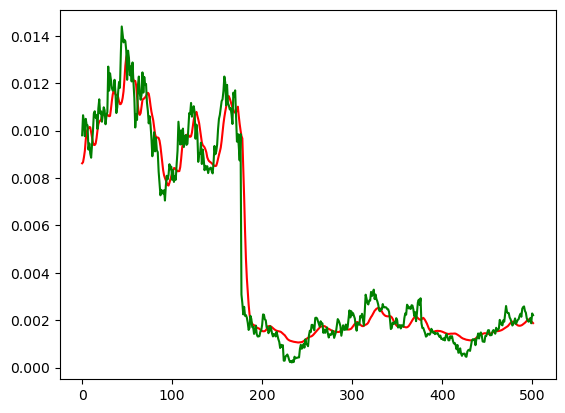

In [12]:
from matplotlib import pyplot as plt
pred_test = CNN_model.predict(X_test)
plt.plot(pred_test,'r')  # 예측 종가값(정규화된 값)
plt.plot(y_test,'g')     # 실제 종가값(정규화된 값)

## 아래 결과값 설명
- 피쳐데이터인 X_test의 10일분 데이터를 넣으면, 그 다음날의 종가를 예측해준다.
- 종가는 X_test의 4번째컬럼값들이다. X의 1번째 항의 첫째날부터 10째날의 데이터를 넣으면 
- y(예측종가)의 첫째항은 다음날인 X_test의 4번째컬럼의 20번째 종가값인 0.00947997이 나온다.
- X의 각 항은 1-10일, 2-11일, 3-12일 이런식으로 진행된다.
- 모든 값은 아직 정규화된 값이다.

In [78]:
# 정규화된 상태로 나옴
display(pred_test[:10])
display(y_test[:10])
display(X_test[:3])


array([[0.00860212],
       [0.00880767],
       [0.00914102],
       [0.00955235],
       [0.01022774],
       [0.01034622],
       [0.01037785],
       [0.01031339],
       [0.01015275],
       [0.00991679]], dtype=float32)

array([0.00947997, 0.00980025, 0.01064671, 0.01037981, 0.00976213,
       0.01049419, 0.01024254, 0.01021967, 0.00919782, 0.00945709],
      dtype=float32)

array([[[0.0097097 , 0.01049631, 0.00943526, 0.01045606],
        [0.01012507, 0.01026779, 0.00937339, 0.00930459],
        [0.00957124, 0.01026017, 0.00959768, 0.00948759],
        [0.00986355, 0.00982597, 0.00860771, 0.00838949],
        [0.00867898, 0.0090947 , 0.0086696 , 0.00893855],
        [0.00935587, 0.00924704, 0.00857678, 0.00872503],
        [0.00860976, 0.00889664, 0.00805087, 0.00811497],
        [0.00849437, 0.00842436, 0.00755588, 0.00743628],
        [0.00843091, 0.00882046, 0.00829836, 0.00860301],
        [0.00910973, 0.00924704, 0.0091491 , 0.00905293]],

       [[0.01012507, 0.01026779, 0.00937339, 0.00930459],
        [0.00957124, 0.01026017, 0.00959768, 0.00948759],
        [0.00986355, 0.00982597, 0.00860771, 0.00838949],
        [0.00867898, 0.0090947 , 0.0086696 , 0.00893855],
        [0.00935587, 0.00924704, 0.00857678, 0.00872503],
        [0.00860976, 0.00889664, 0.00805087, 0.00811497],
        [0.00849437, 0.00842436, 0.00755588, 0.00743628],
        [0.0

# 역정규화
- 정규화된 예측값을 실제 주가값으로 돌리기 위함
- in_val, max_val = minmax[column]에서 각 컬럼의 최소값과 최대값을 min_val, max_val 변수에 저장

In [35]:
display(minmax) # 각 컬럼의 최소,최댓값 -> 이를 이용하여 정규화했음
# 4번째 값 : 종가에 대한 최소/최댓값

[[0.23196400701999664, 72.77999877929688],
 [0.23553599417209625, 73.49250030517578],
 [0.22714300453662872, 72.37999725341797],
 [0.23428599536418915, 73.4124984741211]]

In [13]:
import numpy as np

def inverse_normalize_predictions(predictions, minmax):
    # 타겟(종가) 컬럼의 최소값과 최대값을 추출
    min_val, max_val = minmax[3] 
    predictions = (predictions * (max_val - min_val)) + min_val
    return predictions



In [58]:
# 역정규화 함수 테스트
num = 53.2143

# 정규화
min_val, max_val = minmax[3]   # min_val = minmax[3][0] , max_val = minmax[3][1]
normalized_num = (num - min_val) / (max_val - min_val)
print(normalized_num)

# 역정규화 식 테스트
inverse_num = (normalized_num * (max_val - min_val)) + min_val
print(inverse_num)
# 함수 테스트
inverse_num2 = inverse_normalize_predictions(normalized_num, minmax)
print(inverse_num2)

0.7239861730705095
53.2143
53.2143


In [64]:
# 역정규화 수행
real_pred_test = inverse_normalize_predictions(pred_test, minmax)
real_y_test = inverse_normalize_predictions(y_test, minmax)
display(len(real_pred_test),real_pred_test[0:10])
display(len(y_test),real_y_test[:10],real_y_test.max())

# 역정규화가 잘되었는지 확인해보려면, y_test의 결과값 array를 
# 맨 위에 df(원래데이터셋)의 11번째 행의 종가와 비교해보면된다. (1월 11일)

502

array([[0.86377364],
       [0.8788159 ],
       [0.9032096 ],
       [0.9333102 ],
       [0.98273396],
       [0.99140364],
       [0.99371845],
       [0.98900115],
       [0.97724634],
       [0.9599792 ]], dtype=float32)

502

array([0.9280131 , 0.95145106, 1.013393  , 0.99386203, 0.948661  ,
       1.002232  , 0.98381704, 0.982143  , 0.907366  , 0.92633903],
      dtype=float32)

1.287388

# 실용화해보기
- 최근 주가데이터를 몇개가져와서 똑같이 정규화,전처리 후, 학습시킨 모델에 적용시켜본다.

In [14]:
# 데이터 수집
df2 = yfinance.download('AAPL','2023-12-1','2024-1-18')
df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
display("< original dataset >", df2.tail(10))

# 정규화
dataset2, minmax2 = normalize_data(df2)
values2 = dataset2.values
display("< nomalized dataset >", dataset2.head(21),dataset2.shape)
# 종가 예측은 11번째부터 시작 (12.15일부터)


[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_92325/237320381.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_92325/237320381.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)


'< original dataset >'

,Open,High,Low,Close
Date,,,,
2024-01-03,184.220001,185.880005,183.429993,184.250000
2024-01-04,182.149994,183.089996,180.880005,181.910004
2024-01-05,181.990005,182.759995,180.169998,181.179993
2024-01-08,182.089996,185.600006,181.500000,185.559998
2024-01-09,183.919998,185.149994,182.729996,185.139999
2024-01-10,184.350006,186.399994,183.919998,186.190002
2024-01-11,186.539993,187.050003,183.619995,185.589996
2024-01-12,186.059998,186.740005,185.190002,185.919998
2024-01-16,182.160004,184.259995,180.929993,183.630005


'< nomalized dataset >'

,0,1,2,3
Date,,,,
2023-12-01,0.540895,0.521946,0.538324,0.594212
2023-12-04,0.520000,0.432385,0.432561,0.487300
2023-12-05,0.533731,0.690391,0.594771,0.722977
2023-12-06,0.786865,0.711744,0.709448,0.658004
2023-12-07,0.737911,0.725979,0.797385,0.773184
2023-12-08,0.771940,0.784698,0.802139,0.858240
2023-12-11,0.706865,0.636418,0.668449,0.708801
2023-12-12,0.705074,0.709372,0.686275,0.799174
2023-12-13,0.825074,0.903915,0.872252,0.991140


(31, 4)

In [15]:
# 데이터 전처리
n_steps = 10   # 10일분량씩 쪼개어, 인풋데이터를 만듦
new_X,new_y,new_n_features = data_setup(n_steps, values2)
display("new_X", new_X[:3], new_X.shape)
display("new_y", new_y, new_y.shape)

# 즉, 11번째인 2023-12-15의 종가부터 예측시작

< X > 
 [[[0.5408954  0.5219456  0.53832424 0.59421194]
  [0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]]

 [[0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]
  [0.9707459  0.9276393  1.         0.96810436]]] (21, 10, 4)
< y > 
 [[0.9707

'new_X'

array([[[0.5408954 , 0.5219456 , 0.53832424, 0.59421194],
        [0.5199995 , 0.43238482, 0.43256077, 0.48730043],
        [0.53373146, 0.6903914 , 0.59477085, 0.7229769 ],
        [0.78686523, 0.7117438 , 0.7094475 , 0.6580041 ],
        [0.7379105 , 0.725979  , 0.79738545, 0.773184  ],
        [0.7719399 , 0.7846981 , 0.8021389 , 0.85824025],
        [0.70686543, 0.63641816, 0.6684491 , 0.7088006 ],
        [0.7050745 , 0.7093717 , 0.6862746 , 0.79917353],
        [0.82507414, 0.90391487, 0.8722523 , 0.99114037],
        [1.        , 1.        , 0.95008934, 1.        ]],

       [[0.5199995 , 0.43238482, 0.43256077, 0.48730043],
        [0.53373146, 0.6903914 , 0.59477085, 0.7229769 ],
        [0.78686523, 0.7117438 , 0.7094475 , 0.6580041 ],
        [0.7379105 , 0.725979  , 0.79738545, 0.773184  ],
        [0.7719399 , 0.7846981 , 0.8021389 , 0.85824025],
        [0.70686543, 0.63641816, 0.6684491 , 0.7088006 ],
        [0.7050745 , 0.7093717 , 0.6862746 , 0.79917353],
        [0.8

(21, 10, 4)

'new_y'

array([0.96810436, 0.8688718 , 0.93089205, 0.80626124, 0.7974007 ,
       0.73360944, 0.7011226 , 0.7070287 , 0.73242784, 0.6704076 ,
       0.26343796, 0.18133526, 0.04311935, 0.        , 0.2587125 ,
       0.2339046 , 0.29592484, 0.26048443, 0.27997658, 0.14471418,
       0.08860008], dtype=float32)

(21,)

In [16]:
# 모델로드
CNN_model = load_keras_model('adam','mse')

# 예측하기
print("[ 손실함수 ]")
pred_Apple = CNN_model.predict(new_X)
display(pred_Apple[:5], len(pred_Apple))

[ 손실함수 ]
1/1 [==============================] - 0s 49ms/step


2024-01-22 22:04:38.234631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.8890862 ],
       [0.9117629 ],
       [0.91827214],
       [0.9140449 ],
       [0.92385757]], dtype=float32)

21

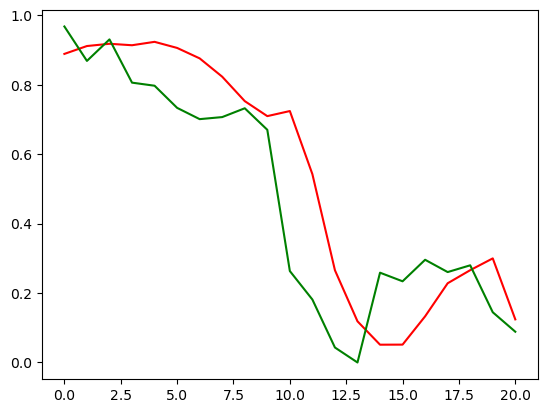

In [17]:
# 정규화 예측값 시각화
plt.plot(pred_Apple,'r')  # 예측 종가값(정규화된 값)
plt.plot(new_y,'g')     # 실제 종가값(정규화된 값)

In [101]:
# 역정규화
real_pred_Apple = inverse_normalize_predictions(pred_Apple, minmax)
real_new_y = inverse_normalize_predictions(new_y, minmax)
display(len(real_pred_Apple),real_pred_Apple[0:10])
display(len(real_new_y),real_new_y[:10])

21

array([[67.06198 ],
       [68.051125],
       [64.720726],
       [66.60722 ],
       [67.64751 ],
       [61.059383],
       [58.2915  ],
       [52.10119 ],
       [50.191578],
       [53.98079 ]], dtype=float32)

21

array([71.07843 , 63.816776, 68.3553  , 59.235046, 58.586647, 53.918518,
       51.541187, 51.973385, 53.83205 , 49.293518], dtype=float32)